# Seed Level on Donation Amount in Kitabisa Website

**BE CAREFUL OF THE PATH, IN ORDER TO NOT OVERWRITE IT**

In [32]:
import pandas as pd
import numpy as np
import math
import glob
import os
import scipy
import warnings
from datetime import date, datetime, time, timedelta
from statsmodels.stats.weightstats import ztest as ztest

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import title
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density  # adds projection='scatter_density', for density scatterplot

import scrape as sc  # for data scraping
import cleaning as cln  # for data cleaning

%matplotlib inline

## Data Reading and Cleaning

First, I am going to read and append all donors and donation properties data which is already scrapped from Kitabisa website. Then after that, I am going to clean the data using the module that I already built. The module for cleaning the data has three purposes:

1. Only taking the important variables and columns for analysis
2. Reformatting the data type to the correct one
3. Aggregating some columns to make it more meaningful for the analysis

#### Collapse, convert to Python code, and run this group of code if we still don't have the clean data!

*You can skip this reading and scraping stage if you already have the data, see the sign of **"you can skip until here!"***

After reading I found there's something wrong in the data. In "created" column, all data is supposed to be datetime format in epoch format. But there are 5 rows of data which is recorded as "Sedekah Masjid". Also, there are 4 rows which do not have amount value (null) in their column. I don't have any choices but to remove the data as the date time donation being made is the most important variables here in the analysis. We cannot assume as the data is pooled and not in order.

After that, I am going to clean and keep only the needed column. For the reference on how the cleaning works, check the script in **"cleaning.py"** file.

***You can skip until here!***

#### Jump here if we already have the clean data!

If we already have a clean data, I don't have to do the above steps again from reading to cleaning. Just read it using pd.read_csv()

In [56]:
url_donors = '/Users/mac/Documents/RU/THESIS/working_thesis/fixed_data/_clean_221025/donors_cleaned_221025.csv'
url_donations = '/Users/mac/Documents/RU/THESIS/working_thesis/fixed_data/_clean_221025/donationprop_cleaned_221025.csv'

df_donors = pd.read_csv(url_donors)
df_donations = pd.read_csv(url_donations)

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/260373214.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_donors = pd.read_csv(url_donors)


#### Data Cleaning

Now, let's start the **data cleaning**. I'll start from checking the data to see if there's a duplicated record. It might happen because of the data scraper error. **Each donation has their own unique ID.** So from there, we can check the duplicated data. If I find there are duplicated records, I will remove it from the data frame.

In [57]:
# Run to check duplicated record and remove it

print(df_donors['id'].duplicated().value_counts())
df_donors.drop_duplicates(subset='id', inplace=True)

print(df_donors['id'].duplicated().value_counts())

False    1770709
True           8
Name: id, dtype: int64
False    1770709
Name: id, dtype: int64


Then, let's take a quick glimpse from the data by counting unique values in every column.

In [58]:
# Counting unique value in every column, donors
display(df_donors.nunique())

# Counting unique value in every column, donation
display(df_donations.nunique())

id               1770708
is_anonymous           5
user.string        33488
amount             11627
created_unix     1556165
created_ts       1556165
time_scrapped     175290
short_url             81
dtype: int64

id                      81
short_url               81
is_forever_running       2
is_open_goal             2
donation_received       81
donation_count          81
donation_target         50
donation_percentage     81
start_ts_utc            81
last_ts_utc             58
days_running            76
days_remaining          37
days_duration           75
is_open_for_donation     2
is_verified              2
campaigner.type          2
category.name           13
time_scraped            81
dtype: int64

I found that the data type for anonimity (is_anonymous) is 5. It's supposed to be 2, since there's only 2 possible values: True and False. Let's check it and if needed, I will cast, drop, or transform the data to the correct format.

In [59]:
# Data types for donor list
display(df_donors.dtypes)

# Data types for donation list
display(df_donations.dtypes)

id               float64
is_anonymous      object
user.string       object
amount           float64
created_unix     float64
created_ts        object
time_scrapped     object
short_url         object
dtype: object

id                        int64
short_url                object
is_forever_running         bool
is_open_goal               bool
donation_received         int64
donation_count            int64
donation_target           int64
donation_percentage     float64
start_ts_utc             object
last_ts_utc              object
days_running              int64
days_remaining            int64
days_duration             int64
is_open_for_donation       bool
is_verified                bool
campaigner.type          object
category.name            object
time_scraped             object
dtype: object

In [60]:
df_donors['is_anonymous'].value_counts()

True      1375323
False      329853
True        54330
False       11202
1000.0          1
Name: is_anonymous, dtype: int64

There's duplicated True and False before the data is transformed. Turns out pandas sees some records as a string, not a boolean. Thus, I cast the string to the Boolean values.

In [61]:
# Before casting the data 
print(df_donors['is_anonymous'].value_counts())

# After casting the data
d = {'True': True, 'False': False, True: True, False: False}
df_donors['is_anonymous'] = df_donors['is_anonymous'].map(d)
print(df_donors['is_anonymous'].value_counts())

True      1375323
False      329853
True        54330
False       11202
1000.0          1
Name: is_anonymous, dtype: int64
True     1429653
False     341055
Name: is_anonymous, dtype: int64


Also, I found that the data type for amount is not correct. Thus, I am going to cast it to float.

In [62]:
df_donors['amount'] = df_donors['amount'].astype(float)
df_donors['amount'].dtypes

dtype('float64')

#### Sorting and Aggregating

After that, I got a clean donors and donation properties file now. The next step is to do some **sorting and aggregating** some columns to make a meaningful analysis. 

There are 7 steps that I am going to do for this stage:

1. Sorting values by the earliest donors
2. Calculating the cummulative sum of the donated amount, to check the donation progress
3. Merging donation properties with donors (only important column, for now without category variables)
4. Calculating the percentage to the completion of every donation
5. Counting how many days have been passed since the donation started
6. Converting created_ts to local timezone as it's converted from epoch, so it's still in UTC format
7. Slicing again to only important column and arrange it to make it easier to read

In [63]:
# 1. Sort values by the earliest donors
df_donors.sort_values(by='created_ts', inplace=True)
df_donors.reset_index(drop=True, inplace=True)

# 2. Calculate the cummulative sum of the donated amount
df_donors['cumsum_amt'] = df_donors.groupby(['short_url'])['amount'].cumsum()

# 3. Merge donation info with donors (only important column, without category variables)
# change this with the data set, make it as comment if we want all data to be extracted
# df_donations = df_donations[df_donations['short_url'] == 'dikihermandagiziburuk']  
col_to_merge_donation = ['short_url', 'donation_target', 'start_ts_utc']
df_donations_no_cat = df_donations[col_to_merge_donation]
df_merged_no_cat = pd.merge(df_donors, df_donations_no_cat, on='short_url')

# 4. Calculate the percentage to the progress of every donation
df_merged_no_cat['percentage_progress'] = df_merged_no_cat['cumsum_amt'] / df_merged_no_cat['donation_target']

# 5. Counting how many days have been passed since the donation starts
df_merged_no_cat['created_ts'] = pd.to_datetime(df_merged_no_cat['created_ts'], format='%Y-%m-%d %H:%M:%S')
df_merged_no_cat['start_ts_utc'] = pd.to_datetime(df_merged_no_cat['start_ts_utc'], format='%Y-%m-%d %H:%M:%S')
df_merged_no_cat['days_passed'] = df_merged_no_cat['created_ts'] - df_merged_no_cat['start_ts_utc']

# 6. Converting created_ts to local timezone as it's converted from epoch, so it's still in UTC format
df_merged_no_cat['created_ts'] = pd.to_datetime(df_merged_no_cat['created_ts'], utc=True, format='%Y-%m-%d %H:%M:%S')
df_merged_no_cat['created_ts'] = df_merged_no_cat['created_ts'].dt.tz_convert('Etc/GMT+7')
df_merged_no_cat['day_ts'] = df_merged_no_cat['created_ts'].dt.day_name()

# 7. Only taking important column and arrange it to make it easier to read
column_arrange = ['id', 'created_ts', 'day_ts', 'user.string', 'is_anonymous', 'amount', 'cumsum_amt', 
                  'percentage_progress', 'days_passed', 'short_url']
df_merged_no_cat = df_merged_no_cat[column_arrange]

df_merged_no_cat.head(10)

,id,created_ts,day_ts,user.string,is_anonymous,amount,cumsum_amt,percentage_progress,days_passed,short_url
0,179444.0,2016-10-25 18:13:00-07:00,Tuesday,NaN,True,50248.0,50248.0,0.000251,28 days 20:03:19,nyfara
1,179533.0,2016-10-25 19:53:02-07:00,Tuesday,NaN,True,20794.0,71042.0,0.000355,28 days 21:43:21,nyfara
2,179535.0,2016-10-25 19:54:10-07:00,Tuesday,NaN,True,20795.0,91837.0,0.000459,28 days 21:44:29,nyfara
3,179599.0,2016-10-25 20:49:46-07:00,Tuesday,NaN,False,500408.0,592245.0,0.002961,28 days 22:40:05,nyfara
4,180525.0,2016-10-26 22:09:51-07:00,Wednesday,NaN,True,100921.0,693166.0,0.003466,30 days 00:00:10,nyfara
5,180706.0,2016-10-27 02:08:49-07:00,Thursday,NaN,True,100983.0,794149.0,0.003971,30 days 03:59:08,nyfara
6,180774.0,2016-10-27 04:20:11-07:00,Thursday,NaN,True,300653.0,1094802.0,0.005474,30 days 06:10:30,nyfara
7,180846.0,2016-10-27 06:22:21-07:00,Thursday,NaN,False,500612.0,1595414.0,0.007977,30 days 08:12:40,nyfara
8,180898.0,2016-10-27 07:59:14-07:00,Thursday,NaN,True,100183.0,1695597.0,0.008478,30 days 09:49:33,nyfara
9,180947.0,2016-10-27 09:11:47-07:00,Thursday,NaN,True,50699.0,1746296.0,0.008731,30 days 11:02:06,nyfara


The previous data frame is for my main analysis. But I am also interested in controlling some variables to check whether seed donation still holds or not. Code below merging my main data frame with categorical variables for controlling.

In [64]:
# Merge category to data frame for seed donation and category analysis
col_to_merge_category = ['start_ts_utc', 'is_open_goal', 'is_open_for_donation', 'is_verified', 'donation_target',
                         'campaigner.type', 'category.name', 'time_scraped', 'short_url', 'is_forever_running']
df_donations_with_cat = df_donations[col_to_merge_category]

column_arrange_cat = ['id', 'created_ts', 'day_ts', 'user.string', 'is_anonymous', 'amount', 'cumsum_amt', 'donation_target',
                      'percentage_progress', 'days_passed', 'is_open_goal', 'is_forever_running',
                      'is_open_for_donation', 'is_verified', 'campaigner.type', 
                      'category.name', 'short_url', 'start_ts_utc', 'time_scraped']
df_merged_with_cat = pd.merge(df_merged_no_cat, df_donations_with_cat, on='short_url')
df_merged_with_cat = df_merged_with_cat[column_arrange_cat]

df_merged_with_cat.head(5)

,id,created_ts,day_ts,user.string,is_anonymous,amount,cumsum_amt,donation_target,percentage_progress,days_passed,is_open_goal,is_forever_running,is_open_for_donation,is_verified,campaigner.type,category.name,short_url,start_ts_utc,time_scraped
0,179444.0,2016-10-25 18:13:00-07:00,Tuesday,NaN,True,50248.0,50248.0,200000000,0.000251,28 days 20:03:19,False,False,False,True,ORGANIZATION,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47
1,179533.0,2016-10-25 19:53:02-07:00,Tuesday,NaN,True,20794.0,71042.0,200000000,0.000355,28 days 21:43:21,False,False,False,True,ORGANIZATION,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47
2,179535.0,2016-10-25 19:54:10-07:00,Tuesday,NaN,True,20795.0,91837.0,200000000,0.000459,28 days 21:44:29,False,False,False,True,ORGANIZATION,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47
3,179599.0,2016-10-25 20:49:46-07:00,Tuesday,NaN,False,500408.0,592245.0,200000000,0.002961,28 days 22:40:05,False,False,False,True,ORGANIZATION,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47
4,180525.0,2016-10-26 22:09:51-07:00,Wednesday,NaN,True,100921.0,693166.0,200000000,0.003466,30 days 00:00:10,False,False,False,True,ORGANIZATION,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47


#### Finalization (Checking Data Before Analysis)

For the final one, before moving to the analysis, let's check once more all the data that I have now by checking the unique value, data type, and missing values.

In [65]:
# Counting the number of unique value
df_merged_with_cat.nunique()

id                      1770708
created_ts              1556164
day_ts                        7
user.string               33488
is_anonymous                  2
amount                    11626
cumsum_amt              1755419
donation_target              50
percentage_progress     1763664
days_passed             1568836
is_open_goal                  2
is_forever_running            2
is_open_for_donation          2
is_verified                   2
campaigner.type               2
category.name                13
short_url                    81
start_ts_utc                 81
time_scraped                 81
dtype: int64

In [66]:
# Checking the data type of every column
df_merged_with_cat.dtypes

id                                        float64
created_ts              datetime64[ns, Etc/GMT+7]
day_ts                                     object
user.string                                object
is_anonymous                               object
amount                                    float64
cumsum_amt                                float64
donation_target                             int64
percentage_progress                       float64
days_passed                       timedelta64[ns]
is_open_goal                                 bool
is_forever_running                           bool
is_open_for_donation                         bool
is_verified                                  bool
campaigner.type                            object
category.name                              object
short_url                                  object
start_ts_utc                               object
time_scraped                               object
dtype: object

In [67]:
# Counting the null value in every column
df_merged_with_cat.isna().sum()

id                            0
created_ts                    0
day_ts                        0
user.string             1678519
is_anonymous                  0
amount                        0
cumsum_amt                    0
donation_target               0
percentage_progress           0
days_passed                   0
is_open_goal                  0
is_forever_running            0
is_open_for_donation          0
is_verified                   0
campaigner.type               0
category.name                 0
short_url                     0
start_ts_utc                  0
time_scraped                  0
dtype: int64

I found an issue with user.string, where the Nan values is around 1 million data. In this data, it means for the people that did not set up their profile picture. To handle this and for the latter analysis, I will convert people who set up profile picture to 1 and the rest of them to 0.

In [84]:
df_merged_with_cat['pp_dummy'] = df_merged_with_cat['user.string']

df_merged_with_cat['pp_dummy'].loc[~df_merged_with_cat['pp_dummy'].isnull()] = 1  # not nan
df_merged_with_cat['pp_dummy'].loc[df_merged_with_cat['pp_dummy'].isnull()] = 0  # nan

df_merged_with_cat['pp_dummy'].isnull().sum()  # to count how many nan values we have

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/1816413063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_with_cat['pp_dummy'].loc[~df_merged_with_cat['pp_dummy'].isnull()] = 1  # not nan
/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/1816413063.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_with_cat['pp_dummy'].loc[df_merged_with_cat['pp_dummy'].isnull()] = 0  # nan


0

Done. I have two data frame now for my analysis.

1. **df_merged_no_cat**: Main analysis, without control variables
2. **df_merged_with_cat**: Extended analysis, to check the effect of control variables

## Data Transformation

This section will explain the transformation of my data for my main analysis. But before that, I have to do some cleaning again first. In this post-cleaning stage, I am going to filter:

1. Any donations with percentage **exceeds 100%**
2. Any donations with percentage **below 80%**
3. Any donations that is running forever

In [85]:
# Duplicate and name the dataframe as df_analysis
df_analysis = df_merged_with_cat

#### Collapse and run this code if you haven't filtered the campaign!

*We can skip this one if we already filtered the data in scraping stage. See the sign of **"you can skip until here!"***

In [86]:
# 1 & 2. Filter any donations with percentage below 80% and exceed 100%
max_percentage = dict(df_analysis.groupby(['short_url'], sort=False)['percentage_progress'].max())
max_percentage_filtered = dict()

for (key, value) in max_percentage.items():
   if value > 0.9:  
   # if value > 0.9 and value < 1:  -> use this instead if we want to filter above 1
       max_percentage_filtered[key] = value

df_analysis = df_analysis.loc[(df_analysis['short_url'].isin(list(max_percentage_filtered.keys())))]
print('The length of new dataframe: ' + str(len(df_analysis)))

The length of new dataframe: 1358523


In [87]:
df_analysis = df_analysis[df_analysis['is_forever_running'] == False]
print('The length of new dataframe: ' + str(len(df_analysis)))

The length of new dataframe: 1354060


In [88]:
df_analysis.columns

Index(['id', 'created_ts', 'day_ts', 'user.string', 'is_anonymous', 'amount',
       'cumsum_amt', 'donation_target', 'percentage_progress', 'days_passed',
       'is_open_goal', 'is_forever_running', 'is_open_for_donation',
       'is_verified', 'campaigner.type', 'category.name', 'short_url',
       'start_ts_utc', 'time_scraped', 'pp_dummy'],
      dtype='object')

***You can skip until here!***

#### Jump here if you already filtered the campaign!

Now, I am going to aggregate and transform some data again for the analysis.

1. Bining data by 10% incremental -> To check the speed rate for the donation
2. Binning data by 50% incremental -> To check the incremental before and after half of the progress completed
3. Thresholding days -> Minimilize the extension of the campaign deadline by the initiator 

In [89]:
# 1. Bining the data by 10% incremental in the percentage progress

df_analysis['progress_bin'] = pd.cut(df_analysis["percentage_progress"],
                                     [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2],
                                     labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'over'])

In [90]:
# 2. Bining the data by 50% incremental in the percentage progress

df_analysis['progress_bin_50pct'] = pd.cut(df_analysis["percentage_progress"],
                                           [0, 0.5, 2], labels=['below50', 'above50'])

In [91]:
# 3. Calculating time difference for successive donation, and giving order for each donation

df_analysis['created_timedelta'] = (df_analysis.groupby('short_url')['created_ts'].diff(-1) * (-1)).shift(1)
df_analysis['created_timedelta_s'] = df_analysis['created_timedelta'].dt.total_seconds()  # convert timedelta to total seconds

df_analysis.reset_index(inplace=True, drop=True)

for row in range(len(df_analysis)):
    if pd.isna(df_analysis.loc[row, 'created_timedelta_s']) == True:
        df_analysis.loc[row, 'created_timedelta'] = df_analysis.loc[row, 'days_passed']
        df_analysis.loc[row, 'created_timedelta_s'] = df_analysis.loc[row, 'days_passed'].total_seconds()

df_analysis['order'] = df_analysis.groupby('short_url').cumcount() + 1 # giving order for each donation

In [92]:
# 4. Thresholding days to control the days passed after the donation started (shown by .max() method)

dayspassed_cat = df_analysis[['short_url', 'days_passed', 'created_timedelta']].groupby('short_url').max().reset_index()
dayspassed_cat

# Parameter to change the days threshold
# 1 year for a safety measurement
days_threshold = 365
timedelta_threshold = 30

for i in range(len(dayspassed_cat)):
    if dayspassed_cat.loc[i, 'days_passed'] < pd.Timedelta(days_threshold, unit='d') and dayspassed_cat.loc[i, 'created_timedelta'] < pd.Timedelta(timedelta_threshold, unit='d'):
        dayspassed_cat.loc[i, 'days_category'] = 'below_threshold'
    else:
        dayspassed_cat.loc[i, 'days_category'] = 'above_threshold'

# Merge df_analysis with days category 
df_analysis = pd.merge(df_analysis, dayspassed_cat[['short_url', 'days_category']], on='short_url')

display(dayspassed_cat)
print('Donation below days threshold: ', dayspassed_cat['days_category'].value_counts()['below_threshold'])
print('Donation above days threshold: ', dayspassed_cat['days_category'].value_counts()['above_threshold'])

,short_url,days_passed,created_timedelta,days_category
0,bantuadikfaizsembuhdaritumormata,266 days 01:39:01,14 days 00:39:56,below_threshold
1,bantuanmedisuntukpasien,37 days 07:33:39,4 days 09:05:34,below_threshold
2,bantuanuntukkesehatan,33 days 03:42:29,17 days 10:01:53,below_threshold
3,bantubangunmesjidpelosok,256 days 06:19:06,55 days 05:33:22,above_threshold
4,bantuhuskyaro,86 days 06:29:31,6 days 11:02:26,below_threshold
5,bantukebutuhangizidekaisya,162 days 19:30:22,17 days 04:05:01,below_threshold
6,bantulansiarenovasigedunggerejanya,640 days 00:30:19,7 days 20:28:03,above_threshold
7,bantulansiasakit,203 days 10:02:46,59 days 16:51:33,above_threshold
8,bantumasjidpq2,600 days 01:11:03,12 days 20:13:22,above_threshold
9,bantuseptiacangkokgi,1289 days 20:04:34,138 days 14:25:05,above_threshold


Donation below days threshold:  24
Donation above days threshold:  30


## Exploratory Data Analysis (EDA)

In this section, I will explore the data using descriptive statistics and visualization to see the shape of the data. 

1. Descriptive statistics for the campaigns
2. Descriptive statistics of donation amount and days passed since the donation starts for **pooled data**
3. Descriptive statistics of donation amount and days passed since the donation starts for **each donation**
4. Analyze the distribution of amount of every donations
5. Analyze the time difference between each donation (timedelta)
6. Descriptive statistics based on the categorical variable

In [97]:
# Function to rename category.name from Indonesia to English

def rename_category(df):
    df['category.name'] = df['category.name'].replace({'Balita & Anak Sakit': 'Childhood Disease', 'Bantuan Pendidikan': 'Education', 'Panti Asuhan': 'Orphans',
                                                       'Rumah Ibadah': 'Place of Worship', 'Kemanusiaan': 'Humanitarian', 'Lingkungan': 'Environment',
                                                       'Bencana Alam': 'Natural Disaster', 'Difabel': 'Disabilities', 'Menolong Hewan': 'Animal Rescue',
                                                       'Bantuan Medis & Kesehatan': 'Medical and Health', 'Kegiatan Sosial': 'Social Activities'})
    return df

In [94]:
df_analysis[['short_url', 'category.name']].drop_duplicates()

,short_url,category.name
0,nyfara,Balita & Anak Sakit
5730,wakafmushafalquran,Bantuan Pendidikan
63787,bekalanakyatim,Panti Asuhan
72526,istiqlalpalestina,Rumah Ibadah
183219,zakatpendidikanrpk,Zakat
185711,zakatyataamafadlan,Zakat
234068,bantuseptiacangkokgi,Balita & Anak Sakit
243615,sedekahberassantri,Panti Asuhan
255427,masjidsantriyatim,Rumah Ibadah
292640,ringankanpalestina,Kemanusiaan


/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/2747258021.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


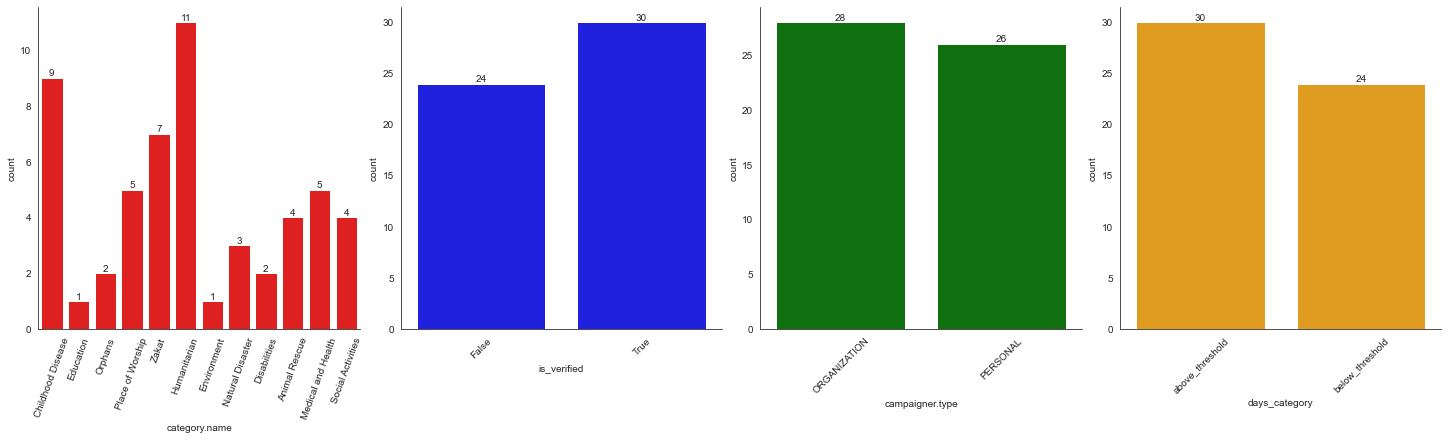

In [95]:
# 1. Plotting descriptive statistics for categorical data
# Coding is not clean yet, should contain again using for loops

def plot_count_campaigns():
    df = df_analysis[['short_url', 'is_verified', 'campaigner.type', 'category.name', 'days_category']].drop_duplicates().reset_index(drop=True)
    df = rename_category(df)
    
    fig = plt.figure(figsize=[20, 6] , constrained_layout=True)
    
    ax = fig.add_subplot(1, 4, 1)
    ax = sns.countplot(data=df, x='category.name', color='red')
    plt.xticks(rotation=70)
    ax.bar_label(ax.containers[0])
    
    ax = fig.add_subplot(1, 4, 2)
    ax = sns.countplot(data=df, x='is_verified', color='blue')
    plt.xticks(rotation=45)
    ax.bar_label(ax.containers[0])
    
    ax = fig.add_subplot(1, 4, 3)
    ax = sns.countplot(data=df, x='campaigner.type', color='green')
    plt.xticks(rotation=45)
    ax.bar_label(ax.containers[0])

    ax = fig.add_subplot(1, 4, 4)
    ax = sns.countplot(data=df, x='days_category', color='orange')
    plt.xticks(rotation=45)
    ax.bar_label(ax.containers[0])
    
    sns.despine()
    fig.show()
    
plot_count_campaigns()

In [25]:
# 2. Descriptive statistics of pooled data for donation
column_describe = ['short_url', 'amount', 'days_passed', 'created_timedelta', 'created_timedelta_s']
df_analysis[column_describe].describe()

,amount,days_passed,created_timedelta,created_timedelta_s
count,1.354060e+06,1354060,1354060,1.354060e+06
mean,2.423304e+04,351 days 01:15:48.441663580,0 days 00:28:26.700433511,1.706700e+03
std,1.838402e+05,437 days 11:45:16.743478824,0 days 12:30:49.611662064,4.504961e+04
min,1.000000e+03,0 days 00:20:47,0 days 00:00:00,0.000000e+00
25%,1.000000e+03,59 days 18:05:16.250000,0 days 00:00:10,1.000000e+01
50%,2.000000e+03,165 days 04:23:59,0 days 00:00:56,5.600000e+01
75%,1.000000e+04,427 days 04:32:02.500000,0 days 00:05:15,3.150000e+02
max,7.200042e+07,2187 days 17:06:38,363 days 06:11:13,3.138547e+07


In [26]:
# 3. Descriptive statistics of each donation
df_analysis[column_describe].groupby('short_url').describe()

amount                 \
                                                       count           mean   
short_url                                                                     
bantuadikfaizsembuhdaritumormata                     13671.0   32036.122522   
bantuanmedisuntukpasien                               3029.0   35538.406405   
bantuanuntukkesehatan                                11186.0   15204.873950   
bantubangunmesjidpelosok                             14489.0   17470.585203   
bantuhuskyaro                                         1707.0   54463.094903   
bantukebutuhangizidekaisya                           13931.0   16475.644318   
bantulansiarenovasigedunggerejanya                    4783.0  129076.465189   
bantulansiasakit                                      2477.0   60511.285426   
bantumasjidpq2                                      229968.0    4571.994525   
bantuseptiacangkokgi                                  9547.0   53205.821515   
bekalanakyatim                                        8739.0   36743.177938   
bergerakbangunmck                                     8552.0   22477.849860   
bersamabantusembuh                                    1395.0   86351.895341   
bisabantudifabelarsim                                 2893.0   47121.512617   
bisalekassembuh                                       1011.0  103969.253215   
bisausahapakrochim                                   12823.0   46253.001092   
dukunganuntuksembuh                                   1318.0   79349.013657   
engeneindonesiaforkanjuruhan                           902.0   22199.811530   
istiqlalpalestina                                   110693.0   39853.134751   
jariyahfirdaus                                       10214.0   20772.816722   
kitabantudikrayyan                                    4978.0   23694.928686   
lawanleukemiaakutabizaralamilumpuhdankritis           8823.0   27832.904114   
maritolonganabul                                      4691.0   49086.342358   
masjidsantriyatim                                    37213.0   30083.423105   
moaindonesiaforkanjuruhan                              834.0   26677.749400   
nyfara                                                5730.0   56143.951832   
operasibayiojol                                      15157.0   17278.365112   
patunganpohon                                        29509.0   37420.460131   
patunganuntukanabul                                   3629.0   37457.159824   
pedulikucingliardankelaparan                         15253.0   19202.786009   
pkuntukaliyul                                         3125.0   59142.784960   
pkuntukdwi                                            3933.0   39921.608441   
pkuntuknarimin                                        4633.0   50123.859270   
prayforkanjuruhan                                    11992.0   19604.015594   
ringankanbebanduafa                                   2943.0   36598.772341   
ringankanpalestina                                    6600.0   32332.895909   
sedekahberassantri                                   11812.0   29092.717829   
sedekahberbagisajadah                                21150.0    9236.705910   
sedekahsembakomasjid                                 38424.0   12508.856444   
smbantuaiman                                         24608.0   17007.759631   
terapiautisdhuafa                                     3981.0   84321.263502   
tlgbayifrandapnyktjantungatresiaanisuspekdownsy...    2169.0  107407.724758   
tubuhputralemahtidakberdaya                           8114.0   34677.699901   
tuhanbantudarentransplantasisumsumtulang             26562.0   95993.547474   
wakafmushafalquran                                   58057.0   25919.811272   
ybkbantudomilawanpenyakitkulitlangka                 11921.0   38159.018035   
yukinfaqyatim                                        44622.0   15671.042670   
zakatbantugurungajidandhuafa                         35379.0   13234.284463   
zakatibq                 

Now, let's take a look at the **(3) donation amount** data. In this step, I want to:

- Analyze the distribution of amount of each donation in the pooled data
- Separate the amount distribution by the donation
- Distribution for amount of each donation in every campaign
- Distribution for amount of each donation in each day
- Distribution for amount of each donation by visibility of the profile (anonymity)
- Distribution for amount of each donation based on people who set up profile picture
- Plotting the data by time difference
- Distribution for amount of each donation in every percentage progress

In [27]:
# Only for aesthetic needs
sns.set_style("white")

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/560028794.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


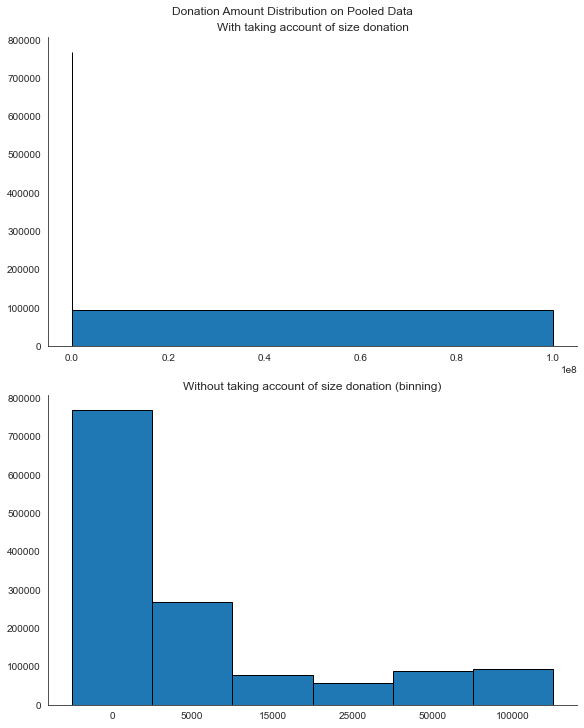

In [28]:
# 4a. Distribution for amount of each donation in the pooled data

# Configure bins based on needs
bins=[0, 5000, 15000, 25000, 50000, 100000, 100000000]

fig = plt.figure(figsize=[8, 10] , constrained_layout=True)

# Original plot, accounting count and amount
ax = fig.add_subplot(211)
ax.hist(df_analysis['amount'], bins=bins, edgecolor='k')
ax.set_title('With taking account of size donation')

# Plot with some modification based on sliced to the bins
ax = fig.add_subplot(212)
h,e = np.histogram(df_analysis['amount'], bins=bins)
ax.bar(range(len(bins)-1),h, width=1, edgecolor='k')
ax.set_xticks(range(len(bins)-1))
ax.set_xticklabels(bins[:-1])
ax.set_title('Without taking account of size donation (binning)')
sns.despine()

fig.suptitle('Donation Amount Distribution on Pooled Data')
fig.show()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/3340048859.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


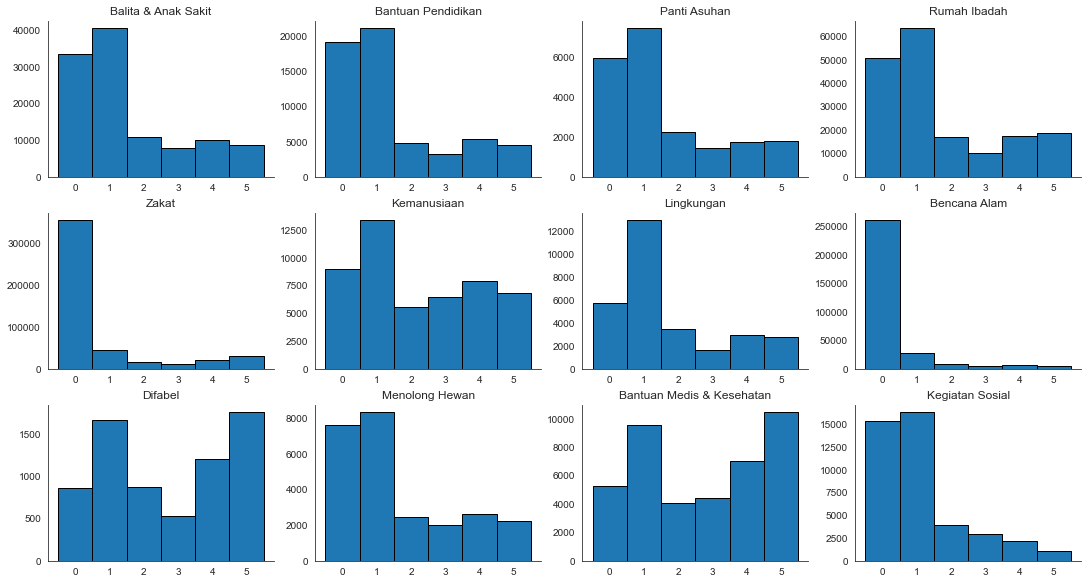

In [29]:
# 4b. Distribution for amount of each donation on every category
# Bin size is still the same with the previous plot 

fig = plt.figure(figsize=[15, 8], constrained_layout=True)

i = 1
for cat in df_analysis['category.name'].unique():
    ax = fig.add_subplot(3, 4, i)  # adjust the size of the subplot based on number of campaigns
    h,e = np.histogram(df_analysis[df_analysis['category.name'] == cat]['amount'], bins=bins)
    ax.bar(range(len(bins)-1),h, width=1, edgecolor='k')
    ax.set_xticks(range(len(bins)-1), )
    # ax.set_xticklabels(bins[:-1])  # turned off to make it much clearer
    ax.set_title(cat)
    i = i + 1

sns.despine()
fig.show()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/2993079954.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


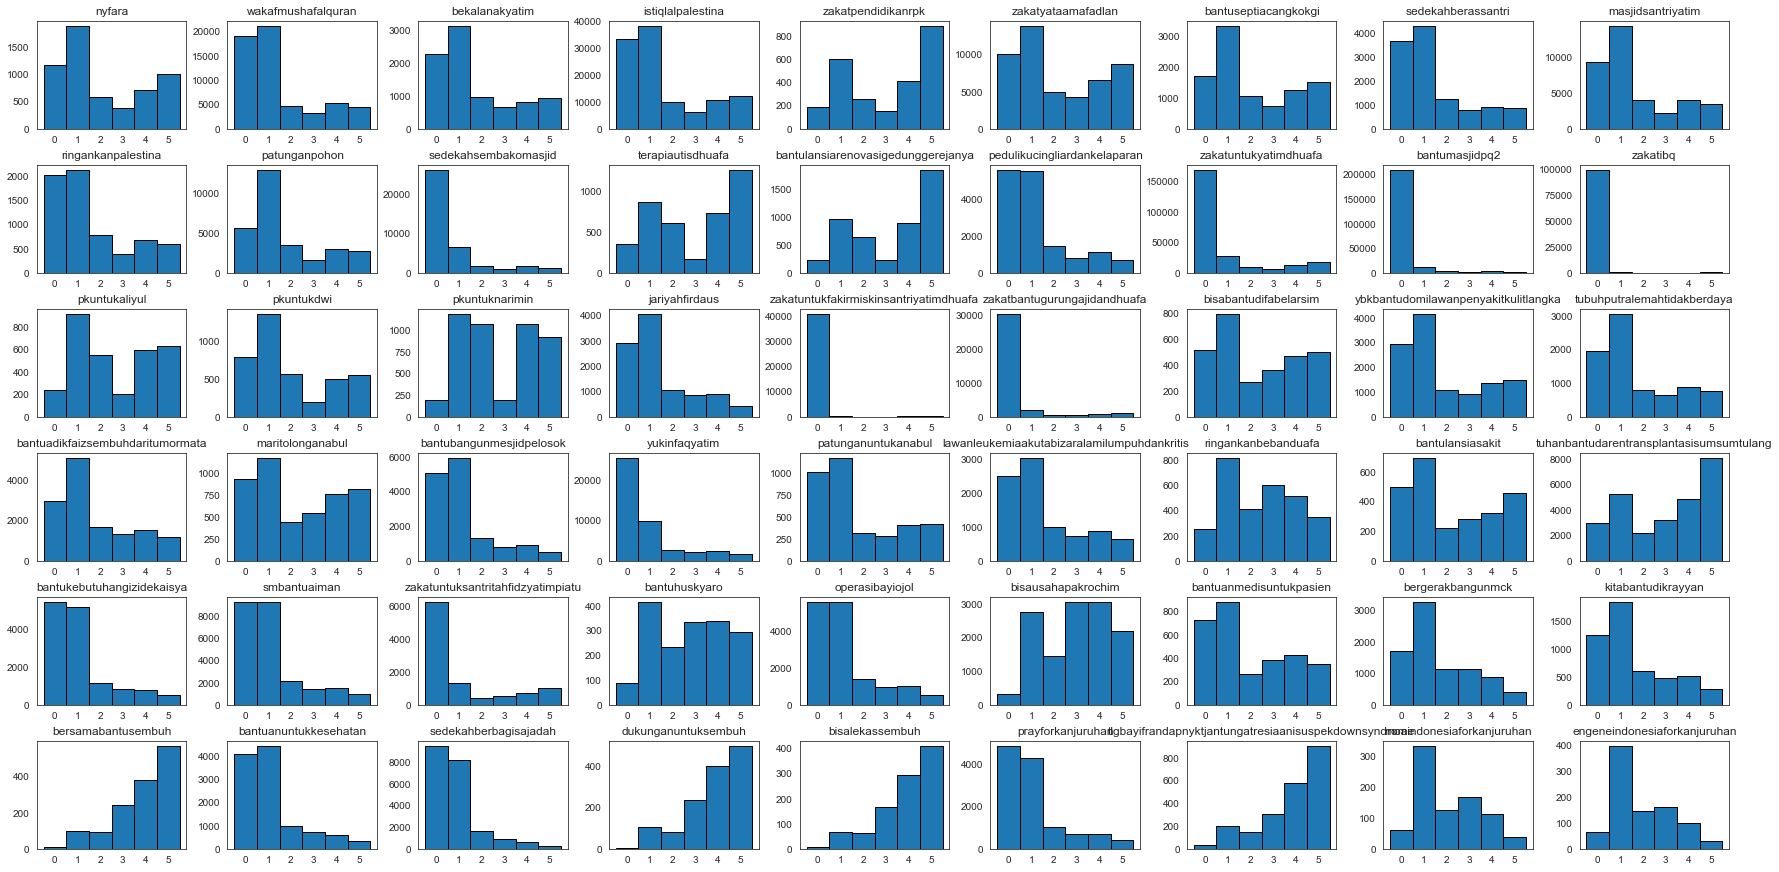

In [30]:
# 4c. Distribution for amount of each donation in every campaign
# Bin size is still the same with the previous plot 

fig = plt.figure(figsize=[24, 12], constrained_layout=True)

i = 1
for donation in df_analysis['short_url'].drop_duplicates():
    ax = fig.add_subplot(6, 9, i)  # adjust the size of the subplot based on number of campaigns
    h,e = np.histogram(df_analysis[df_analysis['short_url'] == donation]['amount'], bins=bins)
    ax.bar(range(len(bins)-1),h, width=1, edgecolor='k')
    ax.set_xticks(range(len(bins)-1), )
    # ax.set_xticklabels(bins[:-1])  # turned off to make it much clearer
    ax.set_title(donation)
    i = i + 1

fig.show()

**Notes for the bins:**

- Bin 0: IDR 0 - 5,000
- Bin 1: IDR 5,000 - 15,000
- Bin 2: IDR 15,000 - 25,000
- Bin 3: IDR 25,000 - 50,000
- Bin 4: IDR 50,000 - 100,000
- Bin 5: IDR 100,000 - 100,000,000 (max. amount)

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/140610259.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


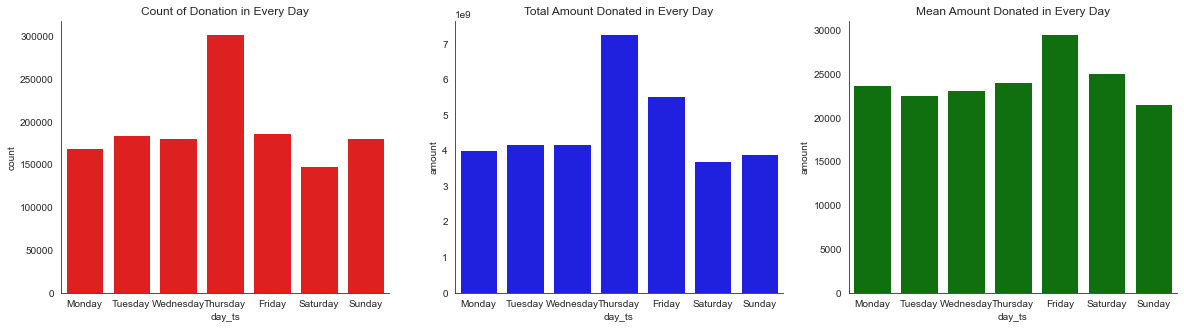

In [180]:
# 4d. Distribution for amount of each donation in each day
# This one is for count of

def plot_amount_by_days():
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    df_d_count = df_analysis.groupby(['day_ts'])['amount'].count().reset_index()
    df_d_sum = df_analysis.groupby(['day_ts'])['amount'].sum().reset_index()
    df_d_mean = pd.DataFrame(df_analysis.groupby('day_ts')['amount'].agg('mean')).reset_index()

    fig = plt.figure(figsize=[20, 5])

    ax1 = fig.add_subplot(1, 3, 1)
    ax1 = sns.barplot(data=df_d_count, x='day_ts', y='amount', order=day_order, color='red')
    ax1.set_ylabel('count')
    ax1.set_title('Count of Donation in Every Day')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2 = sns.barplot(data=df_d_sum, x='day_ts', y='amount', order=day_order, color='blue')
    ax2.set_title('Total Amount Donated in Every Day')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3 = sns.barplot(data=df_d_mean, x='day_ts', y='amount', order=day_order, color='green')
    ax3.set_title('Mean Amount Donated in Every Day')

    sns.despine()
    fig.show()

plot_amount_by_days()

In [31]:
# Function to plot count of amount donated in each days
# Bin size is still the same with the previous plot 

def plot_amount_by_days():
    
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    fig = plt.figure(figsize=[15, 5], constrained_layout=True)

    i = 1
    for day in days:
        ax = fig.add_subplot(2, 4, i)  # adjust the size of the subplot based on number of campaigns
        h,e = np.histogram(df_analysis[df_analysis['day_ts'] == day]['amount'], bins=bins)
        ax.bar(range(len(bins)-1),h, width=1, edgecolor='k')
        ax.set_xticks(range(len(bins)-1), )
        # ax.set_xticklabels(bins[:-1])  # turned off to make it much clearer
        ax.set_title(day)
        i = i + 1

    fig.show()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/4009183878.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


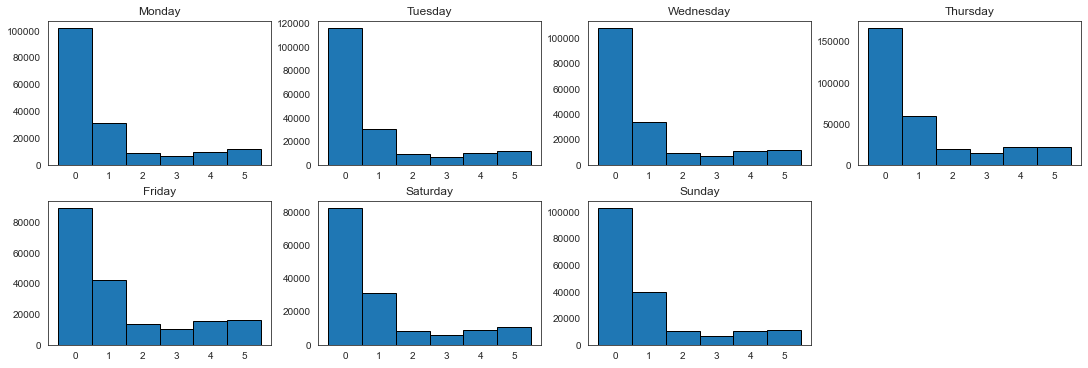

In [32]:
plot_amount_by_days()

,0,5000,25000,15000,50000,100000
day_ts,,,,,,
Monday,0.683953,0.118673,0.067422,0.053050,0.042018,0.034885
Tuesday,0.703410,0.109140,0.064760,0.048991,0.040074,0.033625
Wednesday,0.680340,0.121764,0.071005,0.053408,0.040237,0.033246
Thursday,0.635150,0.133807,0.083737,0.068009,0.045046,0.034250
Friday,0.576834,0.152184,0.098942,0.073238,0.055318,0.043485
Saturday,0.652087,0.135659,0.074720,0.057744,0.044186,0.035604
Sunday,0.677907,0.134945,0.064866,0.054854,0.036934,0.030495


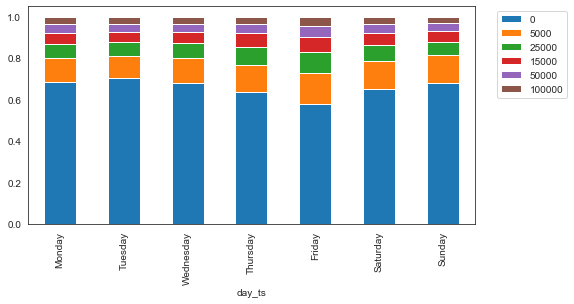

In [249]:
# Function to plot percentage of amount bin by each day
# Bin cuts for amount are 0, 5000, 15000, 25000, 50000, 100000, 100000000 (max)

def plot_size_by_days():
    df = df_analysis
    df['amount_bin'] = pd.cut(df['amount'],
                              [0, 5000, 15000, 25000, 50000, 100000, 100000000],
                              labels=[0, 5000, 15000, 25000, 50000, 100000])
    
    df = df.groupby('day_ts')['amount_bin'].value_counts(normalize=True).unstack(level=1)
    df = df.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    df.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    display(df)

plot_size_by_days()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/539782688.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


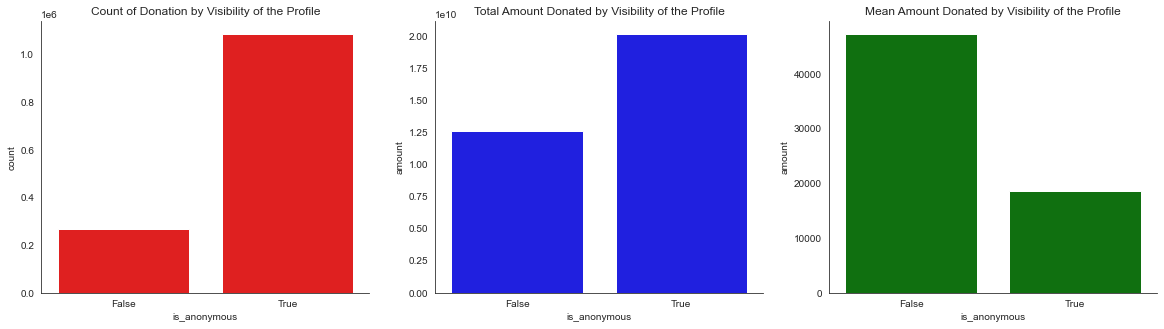

In [41]:
# 4e. Distribution for amount of each donation from the visibility of the profile (anonymous or not)

def plot_amount_by_anonymity():
    df_an_count = df_analysis.groupby(['is_anonymous'])['amount'].count().reset_index()
    df_an_sum = df_analysis.groupby(['is_anonymous'])['amount'].sum().reset_index()
    df_an_mean = pd.DataFrame(df_analysis.groupby('is_anonymous')['amount'].agg('mean')).reset_index()

    fig = plt.figure(figsize=[20, 5])

    ax1 = fig.add_subplot(1, 3, 1)
    ax1 = sns.barplot(data=df_an_count, x='is_anonymous', y='amount', color='red')
    ax1.set_ylabel('count')
    ax1.set_title('Count of Donation by Visibility of the Profile')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2 = sns.barplot(data=df_an_sum, x='is_anonymous', y='amount', color='blue')
    ax2.set_title('Total Amount Donated by Visibility of the Profile')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3 = sns.barplot(data=df_an_mean, x='is_anonymous', y='amount', color='green')
    ax3.set_title('Mean Amount Donated by Visibility of the Profile')
    
    sns.despine()
    fig.show()

plot_amount_by_anonymity()

In [43]:
def anon_ztest():
    anon_true = df_analysis[df_analysis['is_anonymous'] == True]['amount']
    anon_false = df_analysis[df_analysis['is_anonymous'] == False]['amount']
    
    print(ztest(anon_false, anon_true, value=0))
    print('Mean anon_true ', np.mean(anon_true))
    print('Mean anon_false ', np.mean(anon_false))

anon_ztest()

(72.45532832937442, 0.0)
Mean anon_true  18570.5271399554
Mean anon_false  47284.292111688665


/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/155828234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis.rename(columns={"user.string": "profile_pic"}, inplace=True)
/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_12067/155828234.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


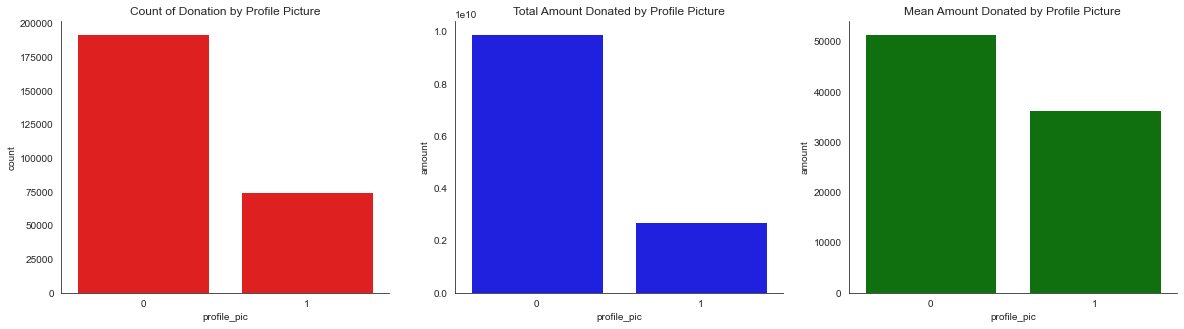

In [40]:
# 4f. Distribution for amount of each donation from the profile picture
# Only including people who are not anonymous

def plot_amount_by_profilepic(df_analysis):
    df_analysis = df_analysis[df_analysis['is_anonymous'] == 0]
    df_analysis.rename(columns={"pp_dummy": "profile_pic"}, inplace=True)
    
    df_pp_count = df_analysis.groupby(['profile_pic'])['amount'].count().reset_index()
    df_pp_sum = df_analysis.groupby(['profile_pic'])['amount'].sum().reset_index()
    df_pp_mean = pd.DataFrame(df_analysis.groupby('profile_pic')['amount'].agg('mean')).reset_index()

    fig = plt.figure(figsize=[20, 5])

    ax1 = fig.add_subplot(1, 3, 1)
    ax1 = sns.barplot(data=df_pp_count, x='profile_pic', y='amount', color='red')
    ax1.set_ylabel('count')
    ax1.set_title('Count of Donation by Profile Picture')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2 = sns.barplot(data=df_pp_sum, x='profile_pic', y='amount', color='blue')
    ax2.set_title('Total Amount Donated by Profile Picture')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3 = sns.barplot(data=df_pp_mean, x='profile_pic', y='amount', color='green')
    ax3.set_title('Mean Amount Donated by Profile Picture')
    
    sns.despine()
    fig.show()

plot_amount_by_profilepic(df_analysis)

In [48]:
def profilepic_ztest():
    df = df_analysis[df_analysis['is_anonymous'] == False]
    pic_true = df[df['pp_dummy'] == 1]['amount']
    pic_false = df[df['is_anonymous'] == 0]['amount']
    
    print(ztest(pic_true, pic_false, value=0))
    print('Total sample test ', len(df))
    print('Mean pic_true ', np.mean(pic_true))
    print('Mean pic_false ', np.mean(pic_false))

profilepic_ztest()

(-9.044160573365142, 1.5081946609845318e-19)
Total sample test  267028
Mean pic_true  36345.77414040211
Mean pic_false  47284.292111688665


/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/4117173428.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


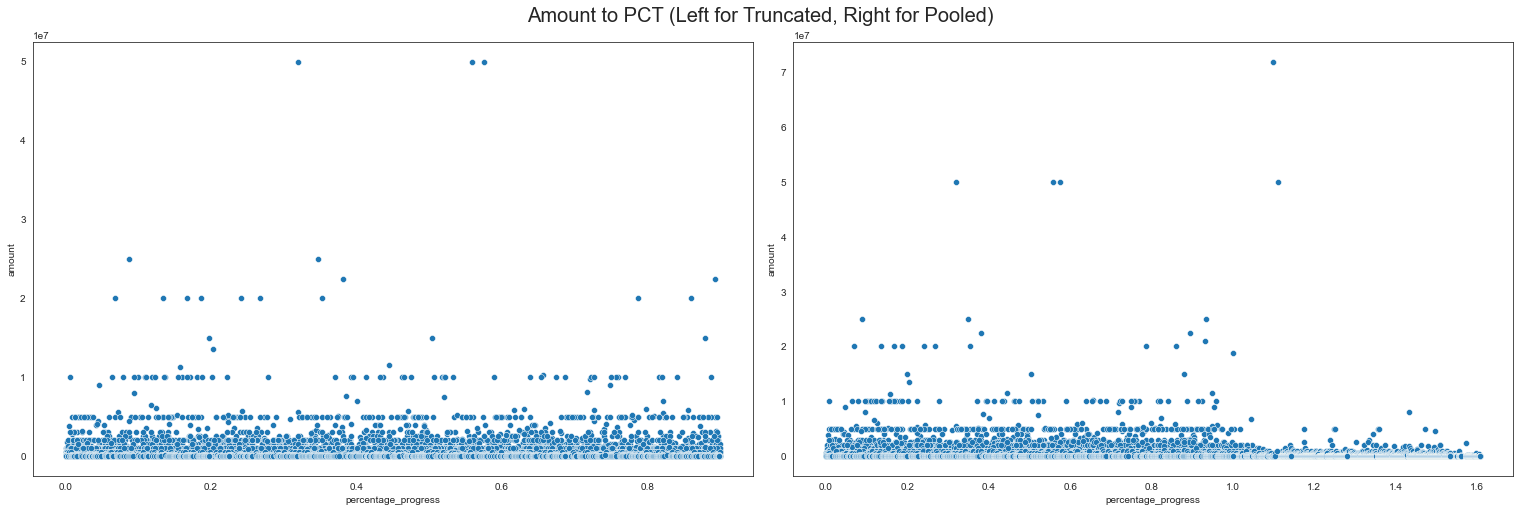

In [35]:
# 3g. Distribution for amount of each donation in every percentage progress

def scatterplot_pct_to_amount():
    
    df = df_analysis
    fig = plt.figure(figsize=[21, 7], constrained_layout=True)
    
    i = 0
    c = 1
    for i in range(0, 2):
        df = df_analysis
        if i == 0:
            df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
            df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()

        ax = fig.add_subplot(1, 2, c)
        sns.scatterplot(data=df, x='percentage_progress', y='amount')
        i = i + 1
        c = c + 1
    
    fig.suptitle('Amount to PCT (Left for Truncated, Right for Pooled)', size=20)
    fig.show()

scatterplot_pct_to_amount()

Now, let's take a look at the **(4) time passed since the donation started**. In this step, I want to:

- Make a scatterplot between progress bin to timedelta (time passed since the donation started) in second 
- Make a scatterplot between percentage of the progress the donation being made to timedelta (time passed since the donation started) in second
- Scatterplot like second bullet, but faceted by each donation

In [36]:
# 5a. Function to make a scatterplot between progress_bin to timedelta
# Time delta is already standardized to their respective campaigns

def scatterplot_timedelta_to_progressbin():
    df = df_analysis[['short_url', 'created_timedelta_s', 'days_category', 'order', 'progress_bin']]
    
    # Remove above-90% and over category
    df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
    df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    
    # Standardize the value of timedelta
    df['std_created_timedelta_new'] = df[['short_url', 'created_timedelta_s']].groupby('short_url').transform(lambda x: (x - x.mean()) / x.std())

    sns.scatterplot(data=df, x="progress_bin", y="std_created_timedelta_new", hue='days_category')

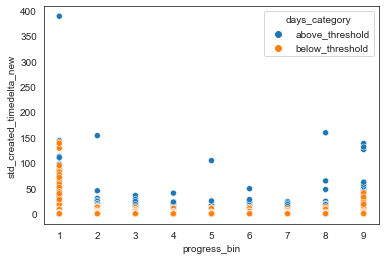

In [37]:
scatterplot_timedelta_to_progressbin()

In [38]:
# 4b. Function to make a line-plot between percentage progress of the donation to timedelta
# Time delta is already standardized to their respective campaigns
# Beware of running this code, taking long time to load the plot

def lineplot_timedelta_pooled(truncated=False):
    
    # Standardizing interval between each donation
    df = df_analysis[['short_url', 'created_timedelta_s', 'days_category', 'percentage_progress', 'progress_bin']]
    df['std_created_timedelta_new'] = df[['short_url', 'created_timedelta_s']].groupby('short_url').transform(lambda x: (x - x.mean()) / x.std())
    
    if truncated == True:
        df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
        df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    
    fig = plt.figure(figsize=[18, 4], constrained_layout=True)
    ax = fig.add_subplot(1, 3, 1)
    ax.title.set_text('Pooled Data')
    g = sns.lineplot(data=df, x='percentage_progress', y='std_created_timedelta_new', hue='days_category', palette='dark')
    
    i = 2
    for days_cat in df['days_category'].unique():
        ax = fig.add_subplot(1, 3, i)
        ax.title.set_text(days_cat)
        g = sns.lineplot(data=df[df['days_category'] == days_cat], x="percentage_progress", y="std_created_timedelta_new")
        i = i + 1
    
    fig.show()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/1313719833.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_created_timedelta_new'] = df[['short_url', 'created_timedelta_s']].groupby('short_url').transform(lambda x: (x - x.mean()) / x.std())
/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/1313719833.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


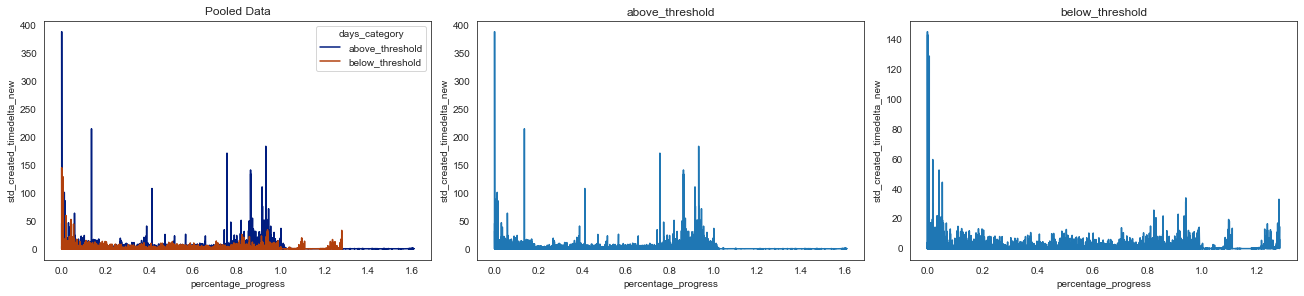

In [39]:
# Plot for pooled data
lineplot_timedelta_pooled()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/1313719833.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_created_timedelta_new'] = df[['short_url', 'created_timedelta_s']].groupby('short_url').transform(lambda x: (x - x.mean()) / x.std())
/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/1313719833.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


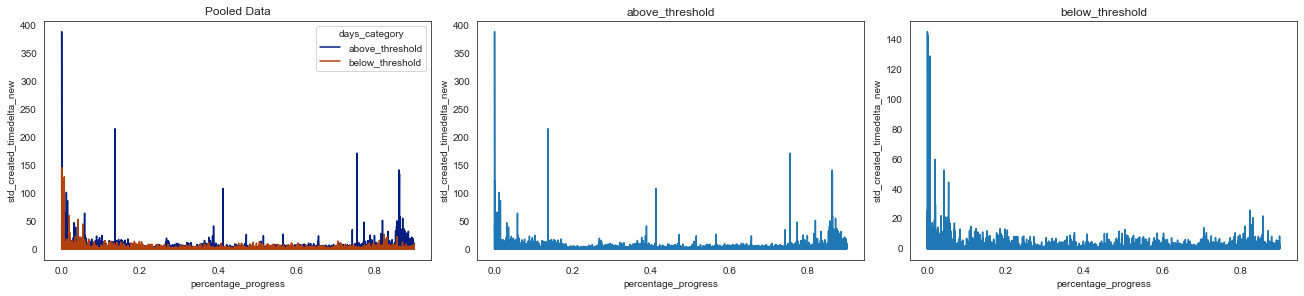

In [40]:
# Plot for Truncated for Campaigns Above 90%
lineplot_timedelta_pooled(truncated=True)

In [41]:
# 5c. Function for plotting the time difference
# Pass the parameter threshold, for the days above or below the threshold

def lineplot_timedelta(threshold):
    i = 1
    fig = plt.figure(figsize=[20, 15], constrained_layout=True)
    df = df_analysis[df_analysis['days_category'] == threshold]
    
    for don in df['short_url'].unique():
        ax = fig.add_subplot(6, 7, i)
        ax.title.set_text(don)
        g = sns.lineplot(data=df[df['short_url'] == don], x="percentage_progress", y="created_timedelta_s")
        g.set(xticklabels=[])
        g.set(yticklabels=[])
        i = i + 1
    
    fig.show()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/1923678206.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


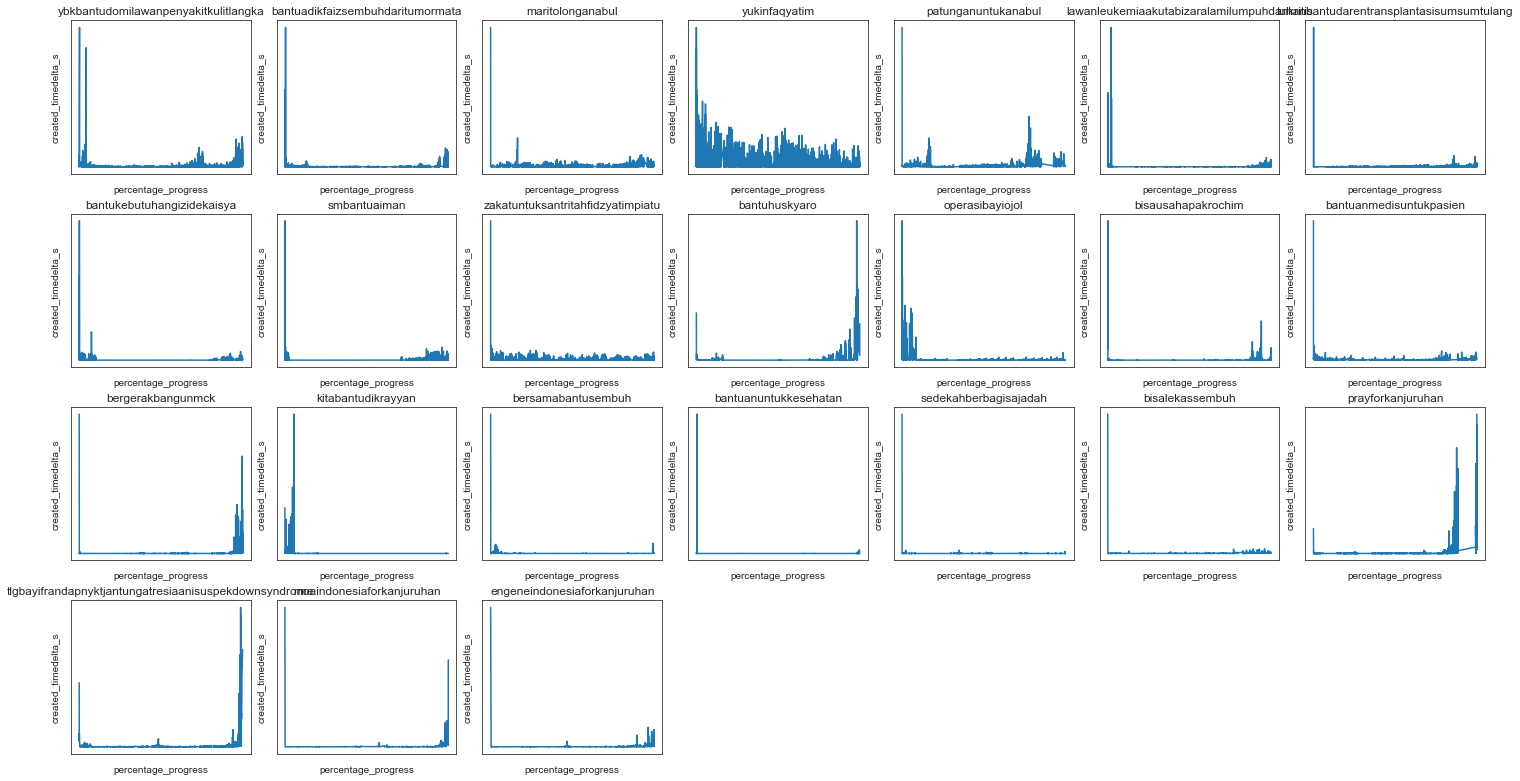

In [42]:
lineplot_timedelta('below_threshold')

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/1923678206.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


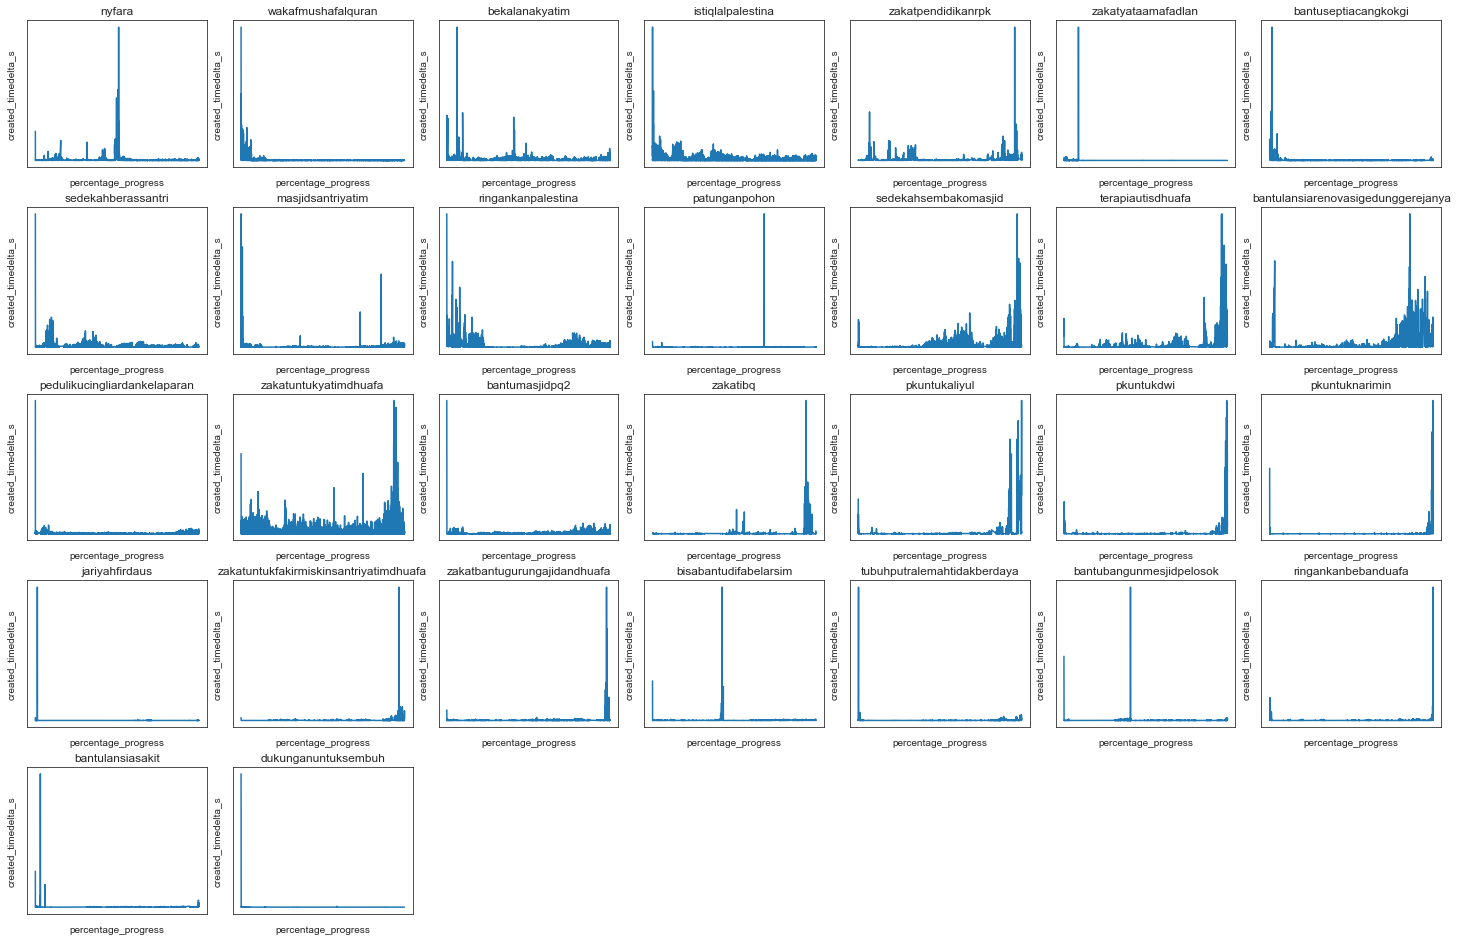

In [43]:
lineplot_timedelta('above_threshold')

Now, I am going to check the **(5) descriptive statistics based on the categorical variable**. First, I will take a look at the donors level first, which is the 'is_anonymous' column. After that, I will move to the donation level. In the laid-out data, it's separated into several steps:

- Counting the value counts of anonimity on pooled data and based on the short_url
- Counting the categorical variable for donation level, including zakat, verification, campaigner type, and category name

In [44]:
# 6a. Counting the value counts of anonimity on pooled data (cont.)
df_analysis['is_anonymous'].value_counts()

True     1087032
False     267028
Name: is_anonymous, dtype: int64

In [45]:
# (cont.) 6a. Counting the value counts of anonimity based on the short_url
df_analysis.groupby(['short_url', 'is_anonymous']).size().unstack(fill_value=0)

is_anonymous,False,True
short_url,,
bantuadikfaizsembuhdaritumormata,6033,7638
bantuanmedisuntukpasien,1172,1857
bantuanuntukkesehatan,3677,7509
bantubangunmesjidpelosok,4022,10467
bantuhuskyaro,635,1072
bantukebutuhangizidekaisya,4282,9649
bantulansiarenovasigedunggerejanya,2255,2528
bantulansiasakit,896,1581
bantumasjidpq2,9381,220587


In [46]:
# 6b. Counting the categorical variable for donation level (cont.)
# Create the data frame first
df_analysis_onlycat = df_analysis[['short_url', 'is_verified', 
                                   'campaigner.type', 'category.name']].drop_duplicates()

In [47]:
# (cont.) 6b. Make for loops to count the values in every categorical variable
for i in ['is_verified', 'campaigner.type', 'category.name']:
    display(df_analysis_onlycat[i].value_counts())

True     30
False    24
Name: is_verified, dtype: int64

ORGANIZATION    28
PERSONAL        26
Name: campaigner.type, dtype: int64

Kemanusiaan                  11
Balita & Anak Sakit           9
Zakat                         7
Rumah Ibadah                  5
Bantuan Medis & Kesehatan     5
Menolong Hewan                4
Kegiatan Sosial               4
Bencana Alam                  3
Panti Asuhan                  2
Difabel                       2
Bantuan Pendidikan            1
Lingkungan                    1
Name: category.name, dtype: int64

## Data Analysis : Main

Now, let's plot the data to my main interest:

### **Is there any correlation between initial seed donation to donation amount?**

In this case, I am going to bin the data by every 10% incremental. And then, I am going to calculate how long until each bin is completed for each donation. After that, I am going to plot the line between progress bin and their completion time by:

1. Pooled data
2. Grouped by days_category 
3. Grouped by category name
4. Grouped by each donation 
5. Grouped by is_verified 

In [48]:
# Function to transform data for our plotting interest 

def pb_datatransform():
    df = df_analysis
    df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
    df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    
    df = df.groupby(['short_url', 'progress_bin']).agg(
        sum_timedelta = ('created_timedelta', 'sum'),
        sum_timedelta_s = ('created_timedelta_s', 'sum'),
        ).reset_index()
    
    df = df.merge(df_analysis[['short_url', 'days_category', 'category.name', 'is_verified', 'campaigner.type', 'donation_target']], how='inner', on='short_url')
    df.drop_duplicates(inplace=True, ignore_index=True)
    df['sum_timedelta_d'] = df['sum_timedelta_s'] / 86400  # convert to days, only for plotting needs
    
    return df

df_main_plot = pb_datatransform()
df_main_plot.head(5)

,short_url,progress_bin,sum_timedelta,sum_timedelta_s,days_category,category.name,is_verified,campaigner.type,donation_target,sum_timedelta_d
0,bantuadikfaizsembuhdaritumormata,1,62 days 23:10:53,5440253.0,below_threshold,Balita & Anak Sakit,True,ORGANIZATION,443270000,62.965891
1,bantuadikfaizsembuhdaritumormata,2,24 days 19:31:21,2143881.0,below_threshold,Balita & Anak Sakit,True,ORGANIZATION,443270000,24.813437
2,bantuadikfaizsembuhdaritumormata,3,5 days 08:28:01,462481.0,below_threshold,Balita & Anak Sakit,True,ORGANIZATION,443270000,5.352789
3,bantuadikfaizsembuhdaritumormata,4,6 days 19:20:38,588038.0,below_threshold,Balita & Anak Sakit,True,ORGANIZATION,443270000,6.805995
4,bantuadikfaizsembuhdaritumormata,5,6 days 07:30:01,545401.0,below_threshold,Balita & Anak Sakit,True,ORGANIZATION,443270000,6.312512


/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/2857045913.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


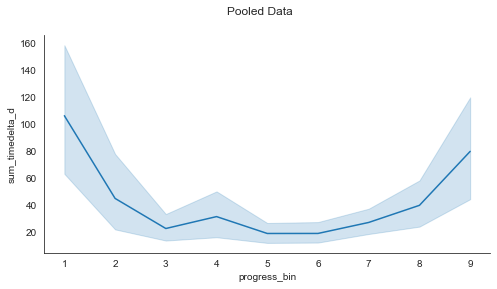

In [49]:
# 1. Plotting the pooled data

# About seaborn lineplot
# It will estimate the mean by aggregating over multiple y values at each x value
# After aggregation, the mean of y values at each x value will be plotted as a line
# The line shadow represents the confidence interval of the estimate.

fig = plt.figure(figsize=[8, 4])

sns.lineplot(data=df_main_plot, x='progress_bin', y='sum_timedelta_d')
# plt.ylim(reversed(plt.ylim()))  # to reverse the y-axis
plt.suptitle('Pooled Data')
sns.despine()

fig.show()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/286515306.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


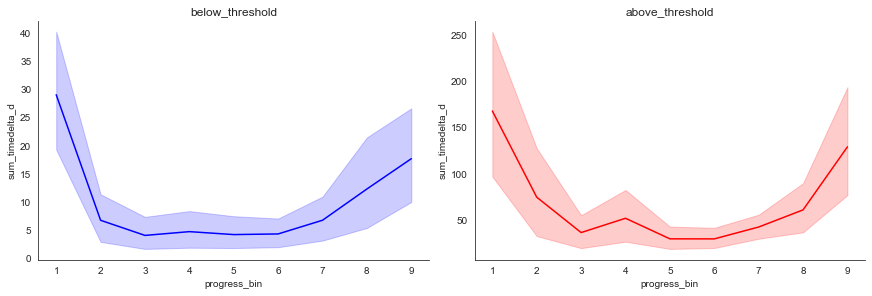

In [50]:
# 2. Plotting by dividing it into their days_category

def plot_main_bydays():
    df = df_main_plot
    
    fig = plt.figure(figsize=[12, 4], constrained_layout=True)
    
    i = 1
    
    for days_cat in df['days_category'].unique():
        df_plot = df[df['days_category'] == days_cat]
        ax = fig.add_subplot(1, 2, i)
        ax.title.set_text(days_cat)
        
        if days_cat == 'above_threshold':
            color = 'red'
        else:
            color = 'blue'
            
        sns.lineplot(data=df_plot[df_plot['days_category'] == days_cat], x='progress_bin', y='sum_timedelta_d', color=color)
        # plt.ylim(reversed(plt.ylim()))  # if you want to reverse
        i = i + 1

    fig.show()
    sns.despine()

plot_main_bydays()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/3371784559.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


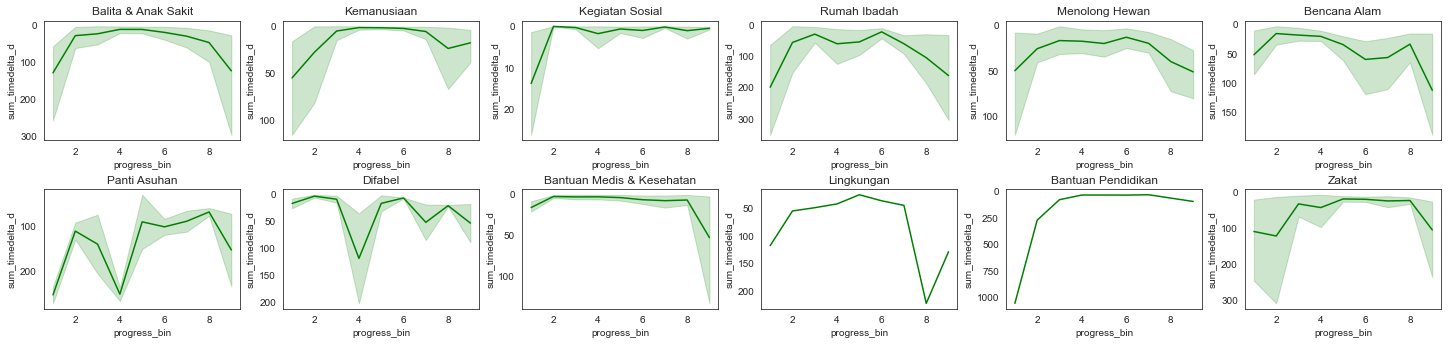

In [51]:
# 3. Plotting by dividing it into their campaign category

def plot_main_bycategory():
    df = df_main_plot
    
    fig = plt.figure(figsize=[20, 8], constrained_layout=True)
    
    i = 1
    
    for cat in df['category.name'].unique():
        df_plot = df[df['category.name'] == cat]
        ax = fig.add_subplot(4, 6, i)
        ax.title.set_text(cat)
        
        sns.lineplot(data=df_plot[df_plot['category.name'] == cat], x='progress_bin', y='sum_timedelta_d', color= 'green')
        plt.ylim(reversed(plt.ylim()))
        i = i + 1

    fig.show()

plot_main_bycategory()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/1045674305.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


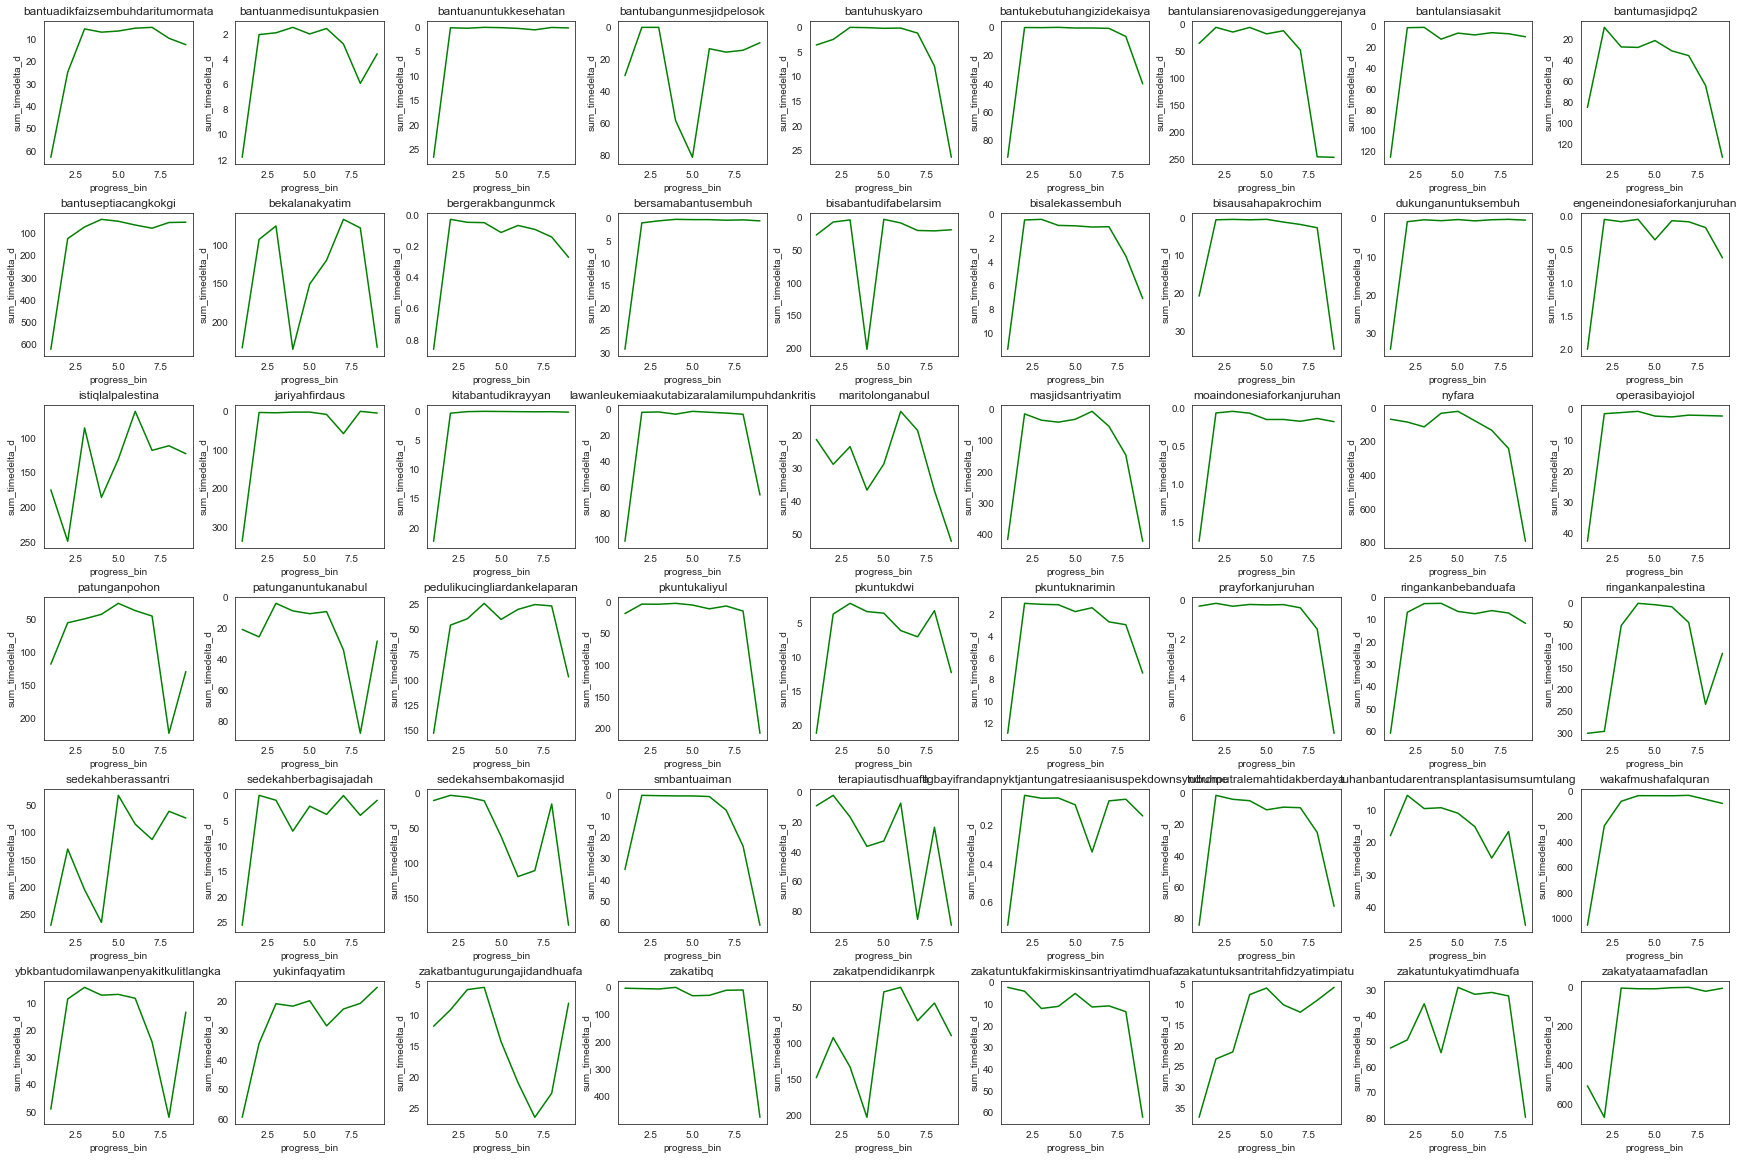

In [52]:
# 4. Plotting it by ther

def plot_main_bycampaign():
    df = df_main_plot
    
    fig = plt.figure(figsize=[24, 16], constrained_layout=True)
    
    i = 1
    
    for url in df['short_url'].unique():
        df_plot = df[df['short_url'] == url]
        ax = fig.add_subplot(6, 9, i)
        ax.title.set_text(url)
        
        sns.lineplot(data=df_plot[df_plot['short_url'] == url], x='progress_bin', y='sum_timedelta_d', color= 'green')
        plt.ylim(reversed(plt.ylim()))
        i = i + 1

    fig.show()

plot_main_bycampaign()

## Data Analysis : Statistical Test

This is the section for more robust test using statistical test such as regression, Kruskal-Wallis test, correlation, and many more.

I am interested in looking for this result, using their respective statistical test.

- Correlation between number of donations over the progress bin using **Poisson Regression**
- Correlation between order of the donation (sorted from the first donation) and days passed between donations using **Polynomial Regression**
- Correlation between progress bin to amount of donation using **Multiple Linear Regression**


In [53]:
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.genmod.families import Poisson

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [54]:
# Duplicating the data, to make a backup from main data
df_statistics = df_analysis

#### Regression Between Percentage Progress to Time Passed - Standardized Variable

In [55]:
'''
Function for density scatterplot needs

:fig: parameter for passing the plt.figure (canvas)
:x: the x-variable for the plot
:y: the y-variable for the plot
'''

def using_mpl_scatter_density(fig, x, y, lim):
    
    # For the density coloring needs
    white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
        (0, '#ffffff'),
        (1e-20, '#440053'),
        (0.2, '#404388'),(0.4, '#2a788e'),
        (0.6, '#21a784'),
        (0.8, '#78d151'),
        (1, '#fde624'),
        ], N=256)
    
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    ax.set_ylim(0,lim)  # Truncated to y=10, to make it clearer to see
    fig.colorbar(density, label='Density')

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


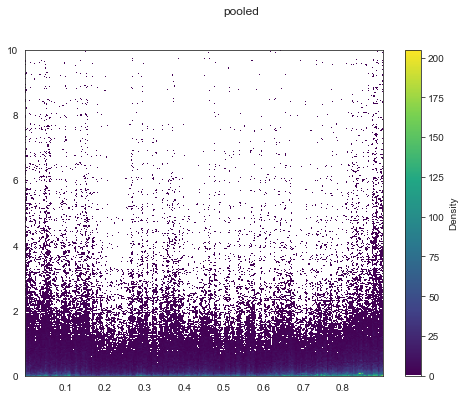

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2758.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:58:59   Log-Likelihood:            -1.7186e+06
No. Observations:             1213156   AIC:                         3.437e+06
Df Residuals:                 1213153   BIC:                         3.437e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1454      0.003     52.850      0.000       0.140       0.151
percentage_progress      -0.9804      0.014    -70.809      0.000      -1.008      -0.953
percentage_progress_2     1.0962      0.015     74.174      0.000       1.067       1.125
==============================================================================
Omnibus:                  4714121.111   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   27971568926010.312
Skew:                          92.614   Prob(JB):                         0.00
Kurtosis:                   23525.975   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
'''
Calculating the polynomial regression between progress bin to time passed 

:cat: To slice the data by days category, defaulted to 'pooled' data
:y_var: The target variable for the model
:lim: Set the y-var limit of the density scatterplot
:model: To pass the model between polynomial regression and the non-powered variable
'''

def polynomial_regress(cat='pooled', y_var='std_created_timedelta', lim=10, model='polynom'):    
    df = df_statistics
    df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
    df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    df['std_created_timedelta'] = df[['short_url', 'created_timedelta_s']].groupby('short_url').transform(lambda x: (x - x.mean()) / x.std())
    df['created_timedelta_s'].replace(0, 1, inplace=True)  # Transform timedelta 0 to 1, as there are some donations that was made at the same time
    df['log_created_timedelta'] = np.log(df['created_timedelta_s'])  # Create log variable from timedelta
    
    
    if cat == 'below_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'above_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'pooled':
        pass

    y = df[y_var].values
    X = df['percentage_progress'].values
    
    # Transform to make the features for polynomial
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(X.reshape(-1, 1))

    # Fitting the polynomial features to linear regression using Scikit
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y)
    y_predicted = poly_reg_model.predict(poly_features)
    
    # Making the density plot
    fig = plt.figure(figsize=(8, 6))
    using_mpl_scatter_density(fig, X, y, lim=lim)
    plt.suptitle(cat)
    plt.show()
    
    # Make the summary from the model using stats model
    df['percentage_progress_2'] = df['percentage_progress'] ** 2
    X_stats = df[['percentage_progress', 'percentage_progress_2']]
    
    if model == 'polynom':
        X_stats = sm.add_constant(X_stats)
        model_stats = sm.OLS(y, X_stats).fit() 
    elif model == 'non-polynom':
        X = sm.add_constant(X)
        model_stats = sm.OLS(y, X).fit() 
    
    return model_stats.summary()

polynomial_regress()

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


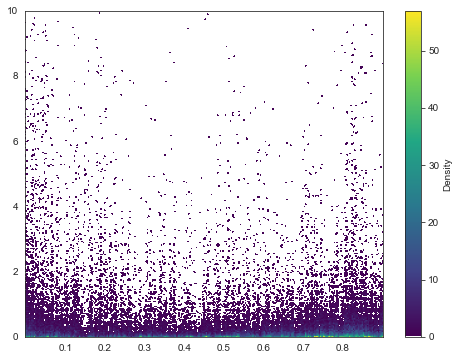

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     853.9
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:46:08   Log-Likelihood:            -3.4664e+05
No. Observations:              244904   AIC:                         6.933e+05
Df Residuals:                  244901   BIC:                         6.933e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2198      0.006     36.244      0.000       0.208       0.232
percentage_progress      -1.2842      0.031    -41.309      0.000      -1.345      -1.223
percentage_progress_2     1.3428      0.034     39.621      0.000       1.276       1.409
==============================================================================
Omnibus:                   828022.854   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     392266045071.130
Skew:                          61.326   Prob(JB):                         0.00
Kurtosis:                    6201.877   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# Sliced by days category -> below threshold
polynomial_regress(cat='below_threshold')

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


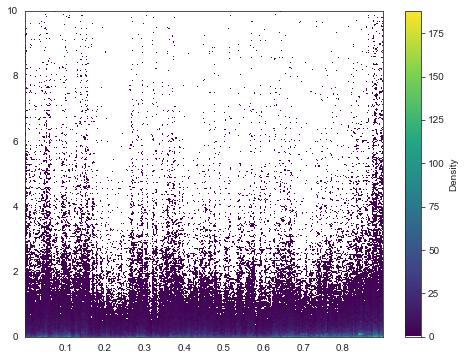

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2013.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:47:08   Log-Likelihood:            -1.3719e+06
No. Observations:              968252   AIC:                         2.744e+06
Df Residuals:                  968249   BIC:                         2.744e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1257      0.003     40.724      0.000       0.120       0.132
percentage_progress      -0.9002      0.015    -58.153      0.000      -0.931      -0.870
percentage_progress_2     1.0306      0.016     62.664      0.000       0.998       1.063
==============================================================================
Omnibus:                  3861294.098   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   31387484753787.523
Skew:                         100.505   Prob(JB):                         0.00
Kurtosis:                   27894.919   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
# Sliced by days category -> above threshold
polynomial_regress(cat='above_threshold')

#### Regression Between Percentage Progress to Time Passed - Unstandardized Variable

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


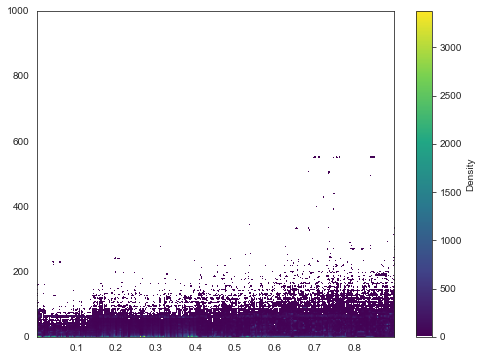

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     312.9
Date:                Wed, 26 Oct 2022   Prob (F-statistic):          1.44e-136
Time:                        09:48:08   Log-Likelihood:            -1.4739e+07
No. Observations:             1213156   AIC:                         2.948e+07
Df Residuals:                 1213153   BIC:                         2.948e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4214.4469    126.107     33.420      0.000    3967.282    4461.612
percentage_progress   -1.588e+04    634.749    -25.014      0.000   -1.71e+04   -1.46e+04
percentage_progress_2  1.641e+04    677.489     24.222      0.000    1.51e+04    1.77e+04
================================================================================
Omnibus:                  7294560.726   Durbin-Watson:                     1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   3059134209117770.500
Skew:                         426.495   Prob(JB):                           0.00
Kurtosis:                  246008.009   Cond. No.                           25.6
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
polynomial_regress(y_var='created_timedelta_s', lim=1000)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


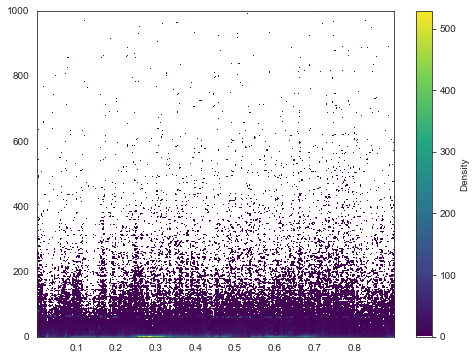

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     468.1
Date:                Wed, 26 Oct 2022   Prob (F-statistic):          1.20e-203
Time:                        09:49:08   Log-Likelihood:            -2.6232e+06
No. Observations:              244904   AIC:                         5.246e+06
Df Residuals:                  244901   BIC:                         5.247e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2405.8598     66.067     36.415      0.000    2276.369    2535.350
percentage_progress   -1.028e+04    338.630    -30.352      0.000   -1.09e+04   -9614.467
percentage_progress_2   1.12e+04    369.176     30.330      0.000    1.05e+04    1.19e+04
==============================================================================
Omnibus:                   956458.817   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1332736580733.602
Skew:                          95.132   Prob(JB):                         0.00
Kurtosis:                   11429.669   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
polynomial_regress(y_var='created_timedelta_s', cat='below_threshold', lim=1000)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


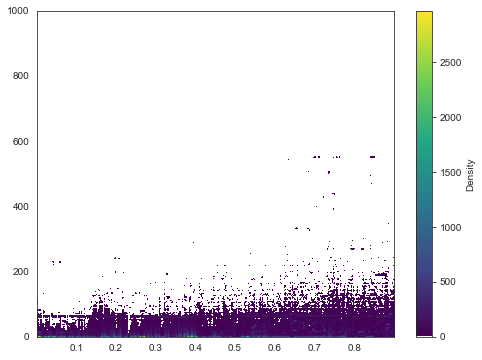

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     237.3
Date:                Wed, 26 Oct 2022   Prob (F-statistic):          9.16e-104
Time:                        09:50:09   Log-Likelihood:            -1.1867e+07
No. Observations:              968252   AIC:                         2.373e+07
Df Residuals:                  968249   BIC:                         2.374e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4677.0331    157.491     29.697      0.000    4368.357    4985.709
percentage_progress   -1.719e+04    789.611    -21.776      0.000   -1.87e+04   -1.56e+04
percentage_progress_2  1.754e+04    838.890     20.912      0.000    1.59e+04    1.92e+04
================================================================================
Omnibus:                  5677688.683   Durbin-Watson:                     1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   1628326465355762.000
Skew:                         387.408   Prob(JB):                           0.00
Kurtosis:                  200902.534   Cond. No.                           25.6
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
polynomial_regress(y_var='created_timedelta_s', cat='above_threshold', lim=1000)

#### Regression Between Percentage Progress to Time Passed - Logged Dependent Variable

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


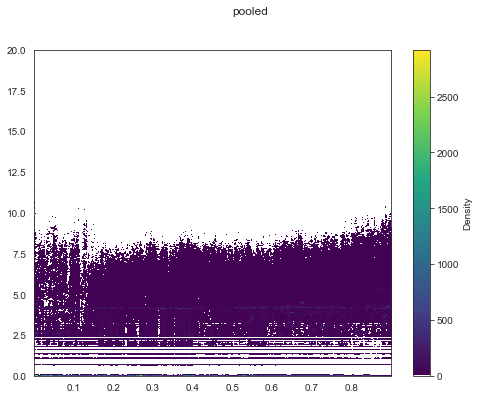

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                 2.203e+04
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:59:04   Log-Likelihood:            -2.8437e+06
No. Observations:             1213156   AIC:                         5.687e+06
Df Residuals:                 1213153   BIC:                         5.687e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.4838      0.007    500.987      0.000       3.470       3.497
percentage_progress      -1.0615      0.035    -30.327      0.000      -1.130      -0.993
percentage_progress_2     3.0544      0.037     81.757      0.000       2.981       3.128
==============================================================================
Omnibus:                    27671.500   Durbin-Watson:                   0.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26880.752
Skew:                           0.331   Prob(JB):                         0.00
Kurtosis:                       2.695   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
polynomial_regress(y_var='log_created_timedelta', lim=20)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


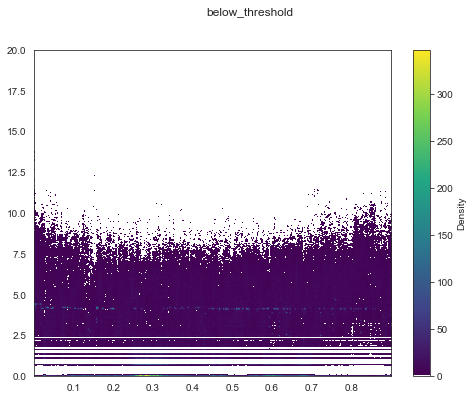

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     6290.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:59:10   Log-Likelihood:            -5.5501e+05
No. Observations:              244904   AIC:                         1.110e+06
Df Residuals:                  244901   BIC:                         1.110e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.3707      0.014    307.763      0.000       4.343       4.399
percentage_progress      -5.7155      0.073    -78.520      0.000      -5.858      -5.573
percentage_progress_2     7.6536      0.079     96.447      0.000       7.498       7.809
==============================================================================
Omnibus:                     9820.699   Durbin-Watson:                   0.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4903.458
Skew:                           0.153   Prob(JB):                         0.00
Kurtosis:                       2.378   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
polynomial_regress(y_var='log_created_timedelta', cat='below_threshold', lim=20)

In [102]:
df_analysis['is_anonymous'].value_counts()

True     1087032
False     267028
Name: is_anonymous, dtype: int64

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


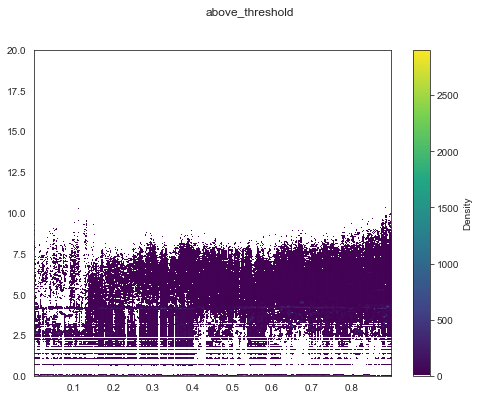

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                 1.839e+04
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:59:27   Log-Likelihood:            -2.2847e+06
No. Observations:              968252   AIC:                         4.569e+06
Df Residuals:                  968249   BIC:                         4.569e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.2564      0.008    410.860      0.000       3.241       3.272
percentage_progress       0.1098      0.040      2.763      0.006       0.032       0.188
percentage_progress_2     1.9203      0.042     45.486      0.000       1.838       2.003
==============================================================================
Omnibus:                    24089.641   Durbin-Watson:                   0.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24920.508
Skew:                           0.376   Prob(JB):                         0.00
Kurtosis:                       2.769   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
polynomial_regress(y_var='log_created_timedelta', cat='above_threshold', lim=20)

#### Regression Between Progress Bin to Time to Complete Each Bin - By Categorical

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/1510723630.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


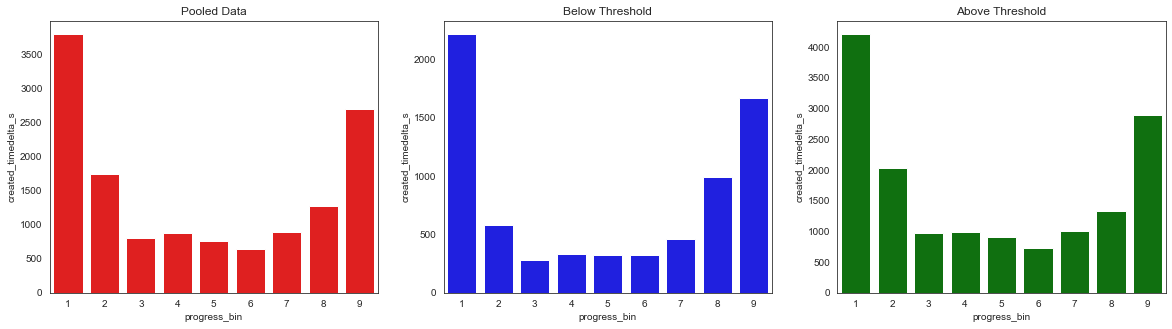

In [65]:
# Plotting using the bar plot by its sum

def plot_progressbin_timetofinish(df_analysis):
    
    df_analysis = df_analysis.drop(df_analysis[(df_analysis['progress_bin'] == 10) | (df_analysis['progress_bin'] == 'over')].index)
    df_analysis['progress_bin'] = df_analysis['progress_bin'].cat.remove_unused_categories()
    
    df_pooled = df_analysis
    df_below = df_analysis[df_analysis['days_category'] == 'below_threshold']
    df_above = df_analysis[df_analysis['days_category'] == 'above_threshold']
    
    def calculate_agg(df):
        f = {'created_timedelta': 'sum', 'created_timedelta_s': 'mean'}
        df = df.groupby(['progress_bin'], as_index=False).agg(f)
        return df
    
    df_pooled = calculate_agg(df_pooled)
    df_below = calculate_agg(df_below)
    df_above = calculate_agg(df_above)

    fig = plt.figure(figsize=[20, 5])

    ax1 = fig.add_subplot(1, 3, 1)
    ax1 = sns.barplot(data=df_pooled, x='progress_bin', y='created_timedelta_s', color='red')
    ax1.set_title('Pooled Data')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2 = sns.barplot(data=df_below, x='progress_bin', y='created_timedelta_s', color='blue')
    ax2.set_title('Below Threshold')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3 = sns.barplot(data=df_above, x='progress_bin', y='created_timedelta_s', color='green')
    ax3.set_title('Above Threshold')
    
    fig.show()

plot_progressbin_timetofinish(df_analysis)

In [66]:
# Casting progress bin variable as category

def regression_progress_to_timedelta(cat='pooled'):
    
    df = df_main_plot  # taking the data frame from our main plot data frame
    if cat == 'below_threshold' or cat == 'above_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'pooled':
        pass
    est = smf.ols(formula='sum_timedelta_d ~ C(progress_bin)', data=df).fit()
    
    return est.summary()
    
regression_progress_to_timedelta()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     5.732
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           5.56e-07
Time:                        09:52:33   Log-Likelihood:                -2889.3
No. Observations:                 486   AIC:                             5797.
Df Residuals:                     477   BIC:                             5834.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              106.1339     12.692      8.362      0.000      81.195     131.072
C(progress_bin)[T.2]   -61.5699     17.949     -3.430      0.001     -96.838     -26.302
C(progress_bin)[T.3]   -83.9684     17.949     -4.678      0.000    -119.237     -48.700
C(progress_bin)[T.4]   -75.1025     17.949     -4.184      0.000    -110.371     -39.834
C(progress_bin)[T.5]   -87.6662     17.949     -4.884      0.000    -122.935     -52.398
C(progress_bin)[T.6]   -87.6407     17.949     -4.883      0.000    -122.909     -52.372
C(progress_bin)[T.7]   -79.4494     17.949     -4.426      0.000    -114.718     -44.181
C(progress_bin)[T.8]   -66.7163     17.949     -3.717      0.000    -101.985     -31.448
C(progress_bin)[T.9]   -26.5438     17.949     -1.479      0.140     -61.812       8.725
==============================================================================
Omnibus:                      531.420   Durbin-Watson:                   1.341
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29380.497
Skew:                           5.016   Prob(JB):                         0.00
Kurtosis:                      39.746   Cond. No.                         9.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
regression_progress_to_timedelta(cat='below_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     7.432
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           1.08e-08
Time:                        09:52:33   Log-Likelihood:                -890.37
No. Observations:                 216   AIC:                             1799.
Df Residuals:                     207   BIC:                             1829.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               29.0584      3.112      9.336      0.000      22.922      35.195
C(progress_bin)[T.2]   -22.2771      4.402     -5.061      0.000     -30.955     -13.599
C(progress_bin)[T.3]   -24.9609      4.402     -5.671      0.000     -33.639     -16.283
C(progress_bin)[T.4]   -24.2932      4.402     -5.519      0.000     -32.971     -15.615
C(progress_bin)[T.5]   -24.8144      4.402     -5.638      0.000     -33.492     -16.137
C(progress_bin)[T.6]   -24.7009      4.402     -5.612      0.000     -33.379     -16.023
C(progress_bin)[T.7]   -22.2697      4.402     -5.059      0.000     -30.947     -13.592
C(progress_bin)[T.8]   -16.7227      4.402     -3.799      0.000     -25.400      -8.045
C(progress_bin)[T.9]   -11.3507      4.402     -2.579      0.011     -20.029      -2.673
==============================================================================
Omnibus:                      110.040   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              528.123
Skew:                           2.025   Prob(JB):                    2.09e-115
Kurtosis:                       9.502   Cond. No.                         9.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
regression_progress_to_timedelta(cat='above_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     5.182
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           5.10e-06
Time:                        09:52:34   Log-Likelihood:                -1661.8
No. Observations:                 270   AIC:                             3342.
Df Residuals:                     261   BIC:                             3374.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              167.7943     21.164      7.928      0.000     126.121     209.468
C(progress_bin)[T.2]   -93.0041     29.930     -3.107      0.002    -151.940     -34.069
C(progress_bin)[T.3]  -131.1744     29.930     -4.383      0.000    -190.110     -72.239
C(progress_bin)[T.4]  -115.7500     29.930     -3.867      0.000    -174.685     -56.815
C(progress_bin)[T.5]  -137.9477     29.930     -4.609      0.000    -196.883     -79.012
C(progress_bin)[T.6]  -137.9925     29.930     -4.610      0.000    -196.928     -79.057
C(progress_bin)[T.7]  -125.1932     29.930     -4.183      0.000    -184.129     -66.258
C(progress_bin)[T.8]  -106.7113     29.930     -3.565      0.000    -165.647     -47.776
C(progress_bin)[T.9]   -38.6983     29.930     -1.293      0.197     -97.634      20.237
==============================================================================
Omnibus:                      242.305   Durbin-Watson:                   1.456
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5124.640
Skew:                           3.603   Prob(JB):                         0.00
Kurtosis:                      23.090   Cond. No.                         9.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Regression Between Progress Bin to Time to Complete Each Bin - Polynomial Regression

In [69]:
# Casting progress bin variable as numerical, then conducting the polynomial regression

def regression_progress_to_timedelta_poly(cat='pooled'):
    
    df = df_main_plot  # taking the data frame from our main plot data frame
    df['progress_bin'] = df['progress_bin'].astype(int)
    
    if cat == 'below_threshold' or cat == 'above_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'pooled':
        pass
    
    df['progress_bin_2'] = df['progress_bin'] ** 2
    y = df['sum_timedelta_d']
    X = df[['progress_bin', 'progress_bin_2']]
    
    X = sm.add_constant(X)
    model_stats = sm.OLS(y, X).fit() 
    
    return model_stats.summary()
    
regression_progress_to_timedelta_poly()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     20.48
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           2.92e-09
Time:                        09:52:34   Log-Likelihood:                -2891.8
No. Observations:                 486   AIC:                             5790.
Df Residuals:                     483   BIC:                             5802.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            136.4329     16.132      8.457      0.000     104.735     168.131
progress_bin     -47.3890      7.407     -6.398      0.000     -61.943     -32.835
progress_bin_2     4.5304      0.722      6.271      0.000       3.111       5.950
==============================================================================
Omnibus:                      534.823   Durbin-Watson:                   1.349
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30130.573
Skew:                           5.064   Prob(JB):                         0.00
Kurtosis:                      40.220   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
regression_progress_to_timedelta_poly(cat='below_threshold')

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/3156829916.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['progress_bin_2'] = df['progress_bin'] ** 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     23.03
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           8.84e-10
Time:                        09:52:35   Log-Likelihood:                -896.50
No. Observations:                 216   AIC:                             1799.
Df Residuals:                     213   BIC:                             1809.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             34.1426      4.016      8.501      0.000      26.225      42.060
progress_bin     -12.4763      1.844     -6.765      0.000     -16.112      -8.841
progress_bin_2     1.2080      0.180      6.716      0.000       0.853       1.563
==============================================================================
Omnibus:                      117.232   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              608.243
Skew:                           2.153   Prob(JB):                    8.35e-133
Kurtosis:                      10.003   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
regression_progress_to_timedelta_poly(cat='above_threshold')

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/3156829916.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['progress_bin_2'] = df['progress_bin'] ** 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     18.67
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           2.57e-08
Time:                        09:52:35   Log-Likelihood:                -1664.0
No. Observations:                 270   AIC:                             3334.
Df Residuals:                     267   BIC:                             3345.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            218.2652     26.846      8.130      0.000     165.409     271.121
progress_bin     -75.3192     12.327     -6.110      0.000     -99.589     -51.050
progress_bin_2     7.1883      1.202      5.979      0.000       4.821       9.555
==============================================================================
Omnibus:                      245.508   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5318.215
Skew:                           3.668   Prob(JB):                         0.00
Kurtosis:                      23.468   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Robustness Test

#### Robustness Test for Timedelta as the Y-Variable

In [72]:
# Function to calculate the regression for y = timedelta

def robustness_timedelta(cat='pooled'):    
    df = df_statistics
    df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
    df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    df['std_created_timedelta'] = df[['short_url', 'created_timedelta_s']].groupby('short_url').transform(lambda x: (x - x.mean()) / x.std())
    
    if cat == 'below_threshold' or cat == 'above_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'pooled':
        pass
    
    df = df.rename(columns={'category.name': 'category_name',
                            'campaigner.type': 'campaigner_type'})
    
    df['percentage_progress_2'] = df['percentage_progress'] ** 2
    
    est = smf.ols(data=df, formula='std_created_timedelta ~ percentage_progress + percentage_progress_2 + day_ts + is_anonymous + category_name + '
                  'campaigner_type + is_verified + days_category + donation_target').fit() 
    
    return est.summary()

In [73]:
robustness_timedelta()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     std_created_timedelta   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.008
Method:                    Least Squares   F-statistic:                     391.6
Date:                   Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                           09:53:23   Log-Likelihood:            -1.7167e+06
No. Observations:                1213156   AIC:                         3.433e+06
Df Residuals:                    1213131   BIC:                         3.434e+06
Df Model:                             24                                         
Covariance Type:               nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.2530      0.006     39.314      0.000       0.240       0.266
day_ts[T.Monday]                               0.0201      0.004      5.616      0.000       0.013       0.027
day_ts[T.Saturday]                             0.0461      0.004     12.509      0.000       0.039       0.053
day_ts[T.Sunday]                               0.0060      0.003      1.723      0.085      -0.001       0.013
day_ts[T.Thursday]                            -0.0573      0.003    -18.183      0.000      -0.063      -0.051
day_ts[T.Tuesday]                              0.0102      0.004      2.905      0.004       0.003       0.017
day_ts[T.Wednesday]                            0.0130      0.004      3.704      0.000       0.006       0.020
is_anonymous[T.True]                          -0.1203      0.002    -49.427      0.000      -0.125      -0.116
category_name[T.Bantuan Medis & Kesehatan]    -0.0189      0.006     -3.117      0.002      -0.031      -0.007
category_name[T.Bantuan Pendidikan]           -0.0048      0.007     -0.713      0.476      -0.018       0.008
category_name[T.Bencana Alam]                 -0.0012      0.005     -0.222      0.824      -0.012       0.009
category_name[T.Difabel]                      -0.0181      0.013     -1.380      0.167      -0.044       0.008
category_name[T.Kegiatan Sosial]               0.0082      0.006      1.278      0.201      -0.004       0.021
category_name[T.Kemanusiaan]                  -0.0182      0.006     -3.168      0.002      -0.029      -0.007
category_name[T.Lingkungan]                    0.0019      0.008      0.231      0.817      -0.014       0.018
category_name[T.Menolong Hewan]               -0.0060      0.008     -0.763      0.445      -0.021       0.009
category_name[T.Panti Asuhan]                 -0.0061      0.009     -0.696      0.486      -0.023       0.011
category_name[T.Rumah Ibadah]                 -0.0152      0.006     -2.704      0.007      -0.026      -0.004
category_name[T.Zakat]                         0.0166      0.005      3.109      0.002       0.006       0.027
campaigner_type[T.PERSONAL]                   -0.0069      0.005     -1.452      0.147      -0.016       0.002
is_verified[T.True]                           -0.0092      0.003     -3.410      0.001      -0.014      -0.004
days_category[T.below_threshold]               0.0003      0.004      0.084      0.933      -0.007       0.008
percentage_progress                           -1.0172      0.014    -72.291      0.000      -1.045      -0.990
percentage_progress_2                          1.1306      0.015     75.279      0.000       1.101       1.160
donation_target                             7.427e-13

In [74]:
robustness_timedelta('below_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     std_created_timedelta   R-squared:                       0.009
Model:                               OLS   Adj. R-squared:                  0.009
Method:                    Least Squares   F-statistic:                     127.6
Date:                   Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                           09:53:31   Log-Likelihood:            -3.4635e+05
No. Observations:                 244904   AIC:                         6.927e+05
Df Residuals:                     244885   BIC:                         6.929e+05
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.2928      0.014     20.485      0.000       0.265       0.321
day_ts[T.Monday]                               0.0767      0.008      9.412      0.000       0.061       0.093
day_ts[T.Saturday]                             0.0606      0.008      8.022      0.000       0.046       0.075
day_ts[T.Sunday]                               0.0282      0.007      4.065      0.000       0.015       0.042
day_ts[T.Thursday]                            -0.0388      0.007     -5.663      0.000      -0.052      -0.025
day_ts[T.Tuesday]                              0.0550      0.008      6.682      0.000       0.039       0.071
day_ts[T.Wednesday]                            0.0718      0.008      9.293      0.000       0.057       0.087
is_anonymous[T.True]                          -0.0435      0.004    -10.007      0.000      -0.052      -0.035
category_name[T.Bantuan Medis & Kesehatan]     0.0140      0.014      1.008      0.313      -0.013       0.041
category_name[T.Bencana Alam]                 -0.0208      0.008     -2.542      0.011      -0.037      -0.005
category_name[T.Kegiatan Sosial]              -0.0198      0.007     -2.811      0.005      -0.034      -0.006
category_name[T.Kemanusiaan]                  -0.0226      0.007     -3.217      0.001      -0.036      -0.009
category_name[T.Menolong Hewan]               -0.0205      0.015     -1.380      0.168      -0.050       0.009
category_name[T.Zakat]                        -0.0594      0.012     -5.073      0.000      -0.082      -0.036
campaigner_type[T.PERSONAL]                   -0.0088      0.006     -1.363      0.173      -0.021       0.004
is_verified[T.True]                           -0.0149      0.011     -1.350      0.177      -0.037       0.007
percentage_progress                           -1.4160      0.032    -44.115      0.000      -1.479      -1.353
percentage_progress_2                          1.4783      0.035     42.183      0.000       1.410       1.547
donation_target                            -2.741e-11   6.47e-12     -4.239      0.000   -4.01e-11   -1.47e-11
==============================================================================
Omnibus:                   828529.868   Durbin-Watson:                   1.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     394572681343.326
Skew:                          61.436   Prob(JB):                         0.00
Kurtosis:                    6220.079   Cond. No.                     2.26e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,

In [75]:
robustness_timedelta('above_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     std_created_timedelta   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.008
Method:                    Least Squares   F-statistic:                     363.4
Date:                   Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                           09:54:02   Log-Likelihood:            -1.3699e+06
No. Observations:                 968252   AIC:                         2.740e+06
Df Residuals:                     968229   BIC:                         2.740e+06
Df Model:                             22                                         
Covariance Type:               nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.2481      0.010     24.515      0.000       0.228       0.268
day_ts[T.Monday]                               0.0101      0.004      2.510      0.012       0.002       0.018
day_ts[T.Saturday]                             0.0443      0.004     10.485      0.000       0.036       0.053
day_ts[T.Sunday]                               0.0016      0.004      0.396      0.692      -0.006       0.010
day_ts[T.Thursday]                            -0.0626      0.004    -17.451      0.000      -0.070      -0.056
day_ts[T.Tuesday]                              0.0021      0.004      0.537      0.591      -0.006       0.010
day_ts[T.Wednesday]                            0.0014      0.004      0.364      0.716      -0.006       0.009
is_anonymous[T.True]                          -0.1562      0.003    -53.063      0.000      -0.162      -0.150
category_name[T.Bantuan Medis & Kesehatan]    -0.0005      0.015     -0.036      0.971      -0.030       0.029
category_name[T.Bantuan Pendidikan]            0.0092      0.010      0.948      0.343      -0.010       0.028
category_name[T.Bencana Alam]                  0.0270      0.009      2.874      0.004       0.009       0.045
category_name[T.Difabel]                      -0.0079      0.015     -0.536      0.592      -0.037       0.021
category_name[T.Kemanusiaan]                  -0.0173      0.011     -1.506      0.132      -0.040       0.005
category_name[T.Lingkungan]                    0.0164      0.011      1.538      0.124      -0.005       0.037
category_name[T.Menolong Hewan]                0.0076      0.012      0.612      0.540      -0.017       0.032
category_name[T.Panti Asuhan]                  0.0078      0.011      0.698      0.485      -0.014       0.030
category_name[T.Rumah Ibadah]                  0.0002      0.009      0.018      0.986      -0.017       0.018
category_name[T.Zakat]                         0.0418      0.009      4.629      0.000       0.024       0.060
campaigner_type[T.PERSONAL]                   -0.0063      0.009     -0.726      0.468      -0.023       0.011
is_verified[T.True]                           -0.0086      0.003     -2.841      0.004      -0.015      -0.003
percentage_progress                           -0.9248      0.016    -58.682      0.000      -0.956      -0.894
percentage_progress_2                          1.0499      0.017     62.789      0.000       1.017       1.083
donation_target                              3.05e-13   5.46e-13      0.559      0.576   -7.65e-13    1.37e-12
==============================================================================
Omnibus:                  3867160.034   Durbin-Watson:                   1.518
Prob(O

In [76]:
# Function to calculate the regression for y = timedelta

def robustness_progress_bin(cat='pooled'):    
    
    df = df_main_plot  # taking the data frame from our main plot data frame
    df = df.rename(columns={'category.name': 'category_name',
                            'campaigner.type': 'campaigner_type'})
    df['progress_bin'] = df['progress_bin'].astype(int)
    df['progress_bin_2'] = df['progress_bin'] ** 2
    
    if cat == 'below_threshold' or cat == 'above_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'pooled':
        pass
    
    est = smf.ols(formula='sum_timedelta_d ~ progress_bin + progress_bin_2 + category_name + days_category + '
                  'campaigner_type + is_verified + donation_target', data=df).fit()
    
    return est.summary()

In [77]:
robustness_progress_bin()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     10.05
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           6.25e-23
Time:                        09:54:02   Log-Likelihood:                -2836.0
No. Observations:                 486   AIC:                             5708.
Df Residuals:                     468   BIC:                             5783.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    142.1602     20.798      6.835      0.000     101.292     183.029
category_name[T.Bantuan Medis & Kesehatan]   -35.1566     15.899     -2.211      0.027     -66.398      -3.915
category_name[T.Bantuan Pendidikan]          100.6957     30.968      3.252      0.001      39.842     161.549
category_name[T.Bencana Alam]                 -1.2795     21.061     -0.061      0.952     -42.665      40.106
category_name[T.Difabel]                     -18.2498     24.571     -0.743      0.458     -66.534      30.034
category_name[T.Kegiatan Sosial]             -18.8477     17.917     -1.052      0.293     -54.055      16.360
category_name[T.Kemanusiaan]                 -17.3316     14.317     -1.211      0.227     -45.465      10.802
category_name[T.Lingkungan]                   -8.6388     31.653     -0.273      0.785     -70.838      53.561
category_name[T.Menolong Hewan]               15.1620     20.544      0.738      0.461     -25.208      55.532
category_name[T.Panti Asuhan]                 59.3789     23.265      2.552      0.011      13.662     105.096
category_name[T.Rumah Ibadah]                 16.9266     19.017      0.890      0.374     -20.444      54.297
category_name[T.Zakat]                       -13.0301     16.704     -0.780      0.436     -45.854      19.794
days_category[T.below_threshold]             -54.5485     11.479     -4.752      0.000     -77.105     -31.992
campaigner_type[T.PERSONAL]                    3.7363     11.531      0.324      0.746     -18.923      26.395
is_verified[T.True]                           29.5449     11.230      2.631      0.009       7.478      51.612
progress_bin                                 -47.3890      6.708     -7.064      0.000     -60.571     -34.207
progress_bin_2                                 4.5304      0.654      6.925      0.000       3.245       5.816
donation_target                             7.218e-09   4.16e-09      1.733      0.084   -9.66e-10    1.54e-08
==============================================================================
Omnibus:                      526.530   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28641.569
Skew:                           4.943   Prob(JB):                         0.00
Kurtosis:                      39.286   Cond. No.                     1.35e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
robustness_progress_bin('below_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     12.47
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           6.86e-18
Time:                        09:54:02   Log-Likelihood:                -862.09
No. Observations:                 216   AIC:                             1748.
Df Residuals:                     204   BIC:                             1789.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     37.2830      5.293      7.044      0.000      26.847      47.719
category_name[T.Bantuan Medis & Kesehatan]   -13.7208      3.805     -3.606      0.000     -21.224      -6.218
category_name[T.Bencana Alam]                  9.4515      5.354      1.765      0.079      -1.104      20.007
category_name[T.Kegiatan Sosial]             -12.0647      3.136     -3.847      0.000     -18.249      -5.881
category_name[T.Kemanusiaan]                 -11.5748      2.774     -4.173      0.000     -17.044      -6.106
category_name[T.Menolong Hewan]                4.5517      4.244      1.073      0.285      -3.815      12.919
category_name[T.Zakat]                        -0.1220      5.269     -0.023      0.982     -10.510      10.266
campaigner_type[T.PERSONAL]                    0.7173      3.083      0.233      0.816      -5.361       6.795
is_verified[T.True]                           -0.8267      2.869     -0.288      0.774      -6.483       4.830
progress_bin                                 -12.4763      1.607     -7.764      0.000     -15.645      -9.308
progress_bin_2                                 1.2080      0.157      7.708      0.000       0.899       1.517
donation_target                             7.129e-09   2.23e-09      3.190      0.002    2.72e-09    1.15e-08
==============================================================================
Omnibus:                      130.403   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              998.402
Skew:                           2.270   Prob(JB):                    1.58e-217
Kurtosis:                      12.503   Cond. No.                     5.03e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
robustness_progress_bin('above_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sum_timedelta_d   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     5.780
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           3.11e-10
Time:                        09:54:03   Log-Likelihood:                -1642.1
No. Observations:                 270   AIC:                             3316.
Df Residuals:                     254   BIC:                             3374.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    187.8949     41.136      4.568      0.000     106.884     268.906
category_name[T.Bantuan Medis & Kesehatan]   -90.5723     33.955     -2.667      0.008    -157.441     -23.704
category_name[T.Bantuan Pendidikan]           72.7057     43.075      1.688      0.093     -12.125     157.536
category_name[T.Bencana Alam]                  9.8464     42.176      0.233      0.816     -73.213      92.905
category_name[T.Difabel]                      -4.0082     41.099     -0.098      0.922     -84.946      76.929
category_name[T.Kemanusiaan]                  -6.4327     35.868     -0.179      0.858     -77.069      64.204
category_name[T.Lingkungan]                  -28.9843     44.451     -0.652      0.515    -116.524      58.555
category_name[T.Menolong Hewan]               17.4766     49.953      0.350      0.727     -80.899     115.852
category_name[T.Panti Asuhan]                 29.8520     33.932      0.880      0.380     -36.972      96.676
category_name[T.Rumah Ibadah]                 22.2344     34.036      0.653      0.514     -44.795      89.264
category_name[T.Zakat]                       -21.3653     30.487     -0.701      0.484     -81.405      38.675
campaigner_type[T.PERSONAL]                   -4.5763     20.546     -0.223      0.824     -45.039      35.886
is_verified[T.True]                           69.2895     24.218      2.861      0.005      21.595     116.984
progress_bin                                 -75.3192     11.650     -6.465      0.000     -98.263     -52.376
progress_bin_2                                 7.1883      1.136      6.326      0.000       4.951       9.426
donation_target                             5.881e-09   5.84e-09      1.007      0.315   -5.62e-09    1.74e-08
==============================================================================
Omnibus:                      232.855   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4257.554
Skew:                           3.455   Prob(JB):                         0.00
Kurtosis:                      21.185   Cond. No.                     2.09e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Effect of Seed Money on Donation Amount

Testing whether the percentage progress affect the amount of donation to the campaign. Then, studying other variables effect that might affect amount of donation to the campaign.

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/2740834643.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


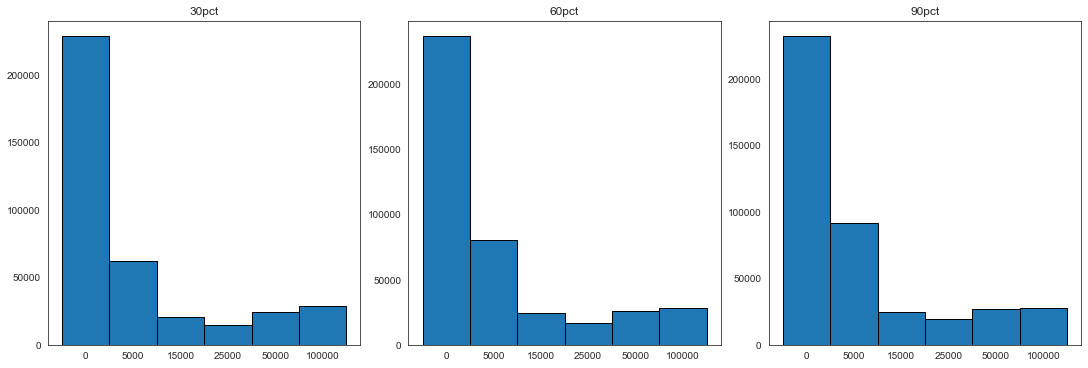

In [112]:
# Plotting amount distribution by splitting into 3 bins

def plot_amount_by_3bin(cat='pooled'):
    
    df = df_analysis
    
    df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
    df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    
    if cat == 'below_threshold' or cat == 'above_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'pooled':
        pass
    
    # creating 3 bins to show amount by each progress bin
    # only make 3 to make it clear to see
    df['progress_bin_3'] = pd.cut(df["percentage_progress"], 
                                           [0, 0.3, 0.6, 0.9],
                                           labels=['30pct', '60pct', '90pct'])
    
    fig = plt.figure(figsize=[15, 5], constrained_layout=True)

    i = 1
    bins=[0, 5000, 15000, 25000, 50000, 100000, 100000000]
    
    for bin in df['progress_bin_3'].unique():
        ax = fig.add_subplot(1, 3, i)  # adjust the size of the subplot based on number of campaigns
        h,e = np.histogram(df[df['progress_bin_3'] == bin]['amount'], bins=bins)
        ax.bar(range(len(bins)-1),h, width=1, edgecolor='k')
        ax.set_xticks(range(len(bins)-1), )
        ax.set_xticks(range(len(bins)-1))
        ax.set_xticklabels(bins[:-1])
        ax.set_title(bin)
        i = i + 1

    fig.show()

plot_amount_by_3bin()

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/2740834643.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


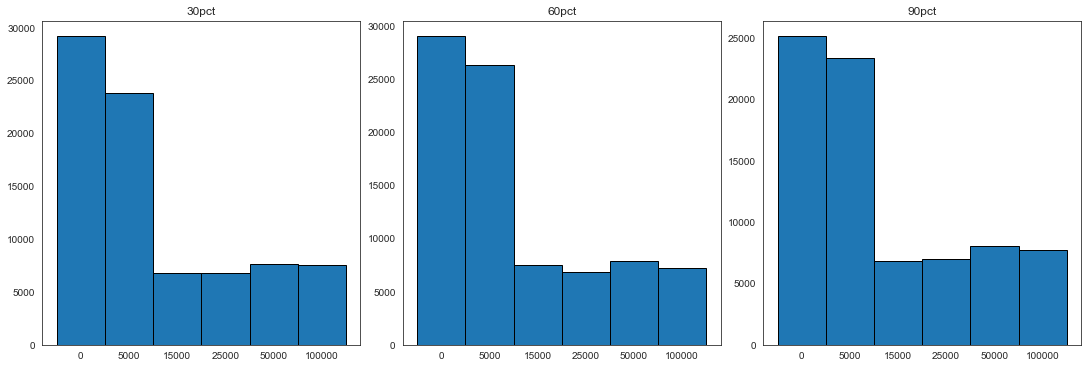

In [114]:
plot_amount_by_3bin(cat='below_threshold')

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/2740834643.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


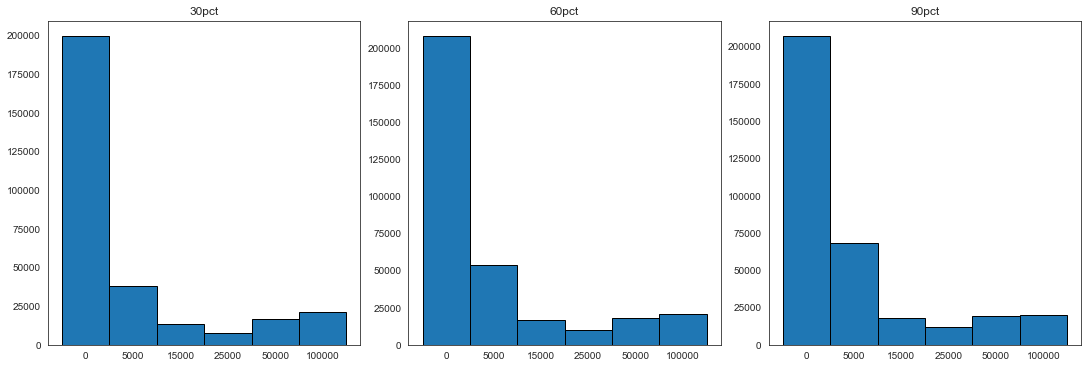

In [113]:
plot_amount_by_3bin(cat='above_threshold')

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_1345/4001719403.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


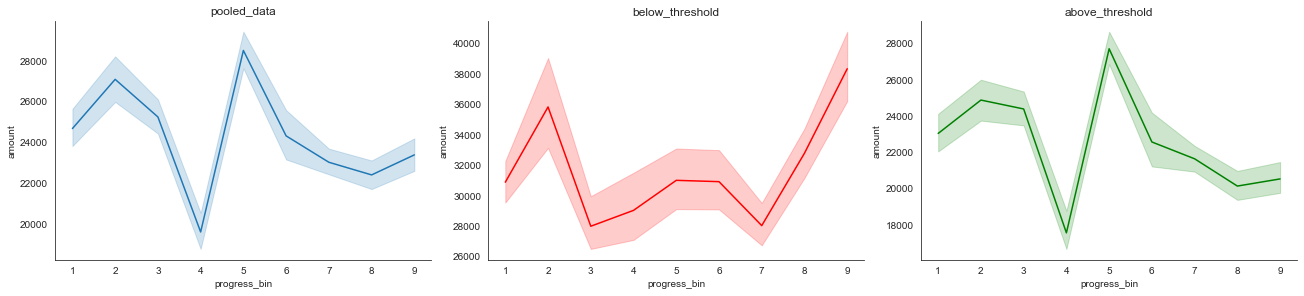

In [138]:
def plot_amount_by_mean_split():
    df = df_statistics
    df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
    df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    
    fig = plt.figure(figsize=[18, 4], constrained_layout=True)
    
    ax = fig.add_subplot(1, 3, 1)
    ax = sns.lineplot(data=df, x='progress_bin', y='amount')
    ax.title.set_text('pooled_data')
    
    i = 2
    
    for days_cat in ['below_threshold', 'above_threshold']:
        df_plot = df[df['days_category'] == days_cat]
        ax = fig.add_subplot(1, 3, i)
        ax.title.set_text(days_cat)
        
        if days_cat == 'below_threshold':
            color = 'red'
        else:
            color = 'green'
            
        sns.lineplot(data=df_plot, x='progress_bin', y='amount', color=color)
        i = i + 1

    fig.show()
    sns.despine()

plot_amount_by_mean_split()

In [104]:
def regression_progress_to_amount(cat='pooled'):
    df = df_statistics
    df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
    df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    
    if cat == 'below_threshold' or cat == 'above_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'pooled':
        pass
    
    est = smf.ols(formula='amount ~ percentage_progress', data=df).fit()
    X = df['percentage_progress']
    y = df['amount']
    y_predicted = est.fittedvalues
    
    # Function to plot, but not really helpful as the dot is too small
    '''plt.figure(figsize=(10, 6))
    plt.title("Regression Between Progress Bin to Amount of Donation", size=16)
    plt.plot(X, y_predicted, c="red")
    plt.scatter(X, y)
    plt.show()'''

    return est.summary()
    
regression_progress_to_amount()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     30.07
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           4.17e-08
Time:                        12:00:34   Log-Likelihood:            -1.6318e+07
No. Observations:             1213156   AIC:                         3.264e+07
Df Residuals:                 1213154   BIC:                         3.264e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.547e+04    310.265     82.101      0.000    2.49e+04    2.61e+04
percentage_progress -3226.2385    588.329     -5.484      0.000   -4379.344   -2073.133
==============================================================================
Omnibus:                  4907352.274   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   26993106905255.477
Skew:                         105.556   Prob(JB):                         0.00
Kurtosis:                   23110.641   Cond. No.                         4.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
regression_progress_to_amount(cat='below_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.771
Date:                Wed, 26 Oct 2022   Prob (F-statistic):            0.00927
Time:                        12:00:48   Log-Likelihood:            -3.2886e+06
No. Observations:              244904   AIC:                         6.577e+06
Df Residuals:                  244902   BIC:                         6.577e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.981e+04    670.070     44.490      0.000    2.85e+04    3.11e+04
percentage_progress  3422.0828   1315.130      2.602      0.009     844.463    5999.702
==============================================================================
Omnibus:                   800330.450   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     298473047324.598
Skew:                          55.525   Prob(JB):                         0.00
Kurtosis:                    5410.153   Cond. No.                         4.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
regression_progress_to_amount(cat='above_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     41.46
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           1.21e-10
Time:                        12:01:18   Log-Likelihood:            -1.3029e+07
No. Observations:              968252   AIC:                         2.606e+07
Df Residuals:                  968250   BIC:                         2.606e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             2.41e+04    349.961     68.864      0.000    2.34e+04    2.48e+04
percentage_progress -4237.1768    658.084     -6.439      0.000   -5526.998   -2947.355
==============================================================================
Omnibus:                  4046156.369   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   29691465618674.527
Skew:                         117.266   Prob(JB):                         0.00
Kurtosis:                   27130.577   Cond. No.                         4.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
'''
Function to calculate the regression, only for categorical 

:cat: Write the column to do the regression calculation
:showplot: True or False, if you want to show the plot or not
'''

def regression_category(cat, showplot=True):
    df = df_statistics
    df = df.rename(columns={'category.name': 'category_name',
                            'campaigner.type': 'campaigner_type',
                            'user.string': 'profile_pic'})

    est = smf.ols(formula=f'amount ~ {cat}', data=df).fit()
    X = df[cat]
    y = df['amount']
    y_predicted = est.fittedvalues
    
    if showplot==True:
        fig = plt.figure(figsize=[12, 10])
        g = sns.stripplot(data=df, x=cat, y='amount')
        g.set_xticklabels(g.get_xticklabels(), rotation=45)

    return est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     784.2
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:54:14   Log-Likelihood:            -1.8331e+07
No. Observations:             1354060   AIC:                         3.666e+07
Df Residuals:                 1354048   BIC:                         3.666e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   2.833e+04    548.810     51.630      0.000    2.73e+04    2.94e+04
category_name[T.Bantuan Medis & Kesehatan]   5.12e+04   1060.653     48.275      0.000    4.91e+04    5.33e+04
category_name[T.Bantuan Pendidikan]        -2415.1263    937.897     -2.575      0.010   -4253.372    -576.881
category_name[T.Bencana Alam]              -2.121e+04    639.127    -33.180      0.000   -2.25e+04      -2e+04
category_name[T.Difabel]                    4.033e+04   2277.451     17.709      0.000    3.59e+04    4.48e+04
category_name[T.Kegiatan Sosial]           -1.451e+04   1051.104    -13.806      0.000   -1.66e+04   -1.25e+04
category_name[T.Kemanusiaan]                1.226e+04    992.876     12.350      0.000    1.03e+04    1.42e+04
category_name[T.Lingkungan]                 9085.5226   1199.696      7.573      0.000    6734.160    1.14e+04
category_name[T.Menolong Hewan]             1414.4558   1276.580      1.108      0.268   -1087.596    3916.508
category_name[T.Panti Asuhan]               4011.0220   1391.168      2.883      0.004    1284.380    6737.664
category_name[T.Rumah Ibadah]               8947.6629    700.365     12.776      0.000    7574.972    1.03e+04
category_name[T.Zakat]                     -6474.1553    609.195    -10.627      0.000   -7668.157   -5280.154
==============================================================================
Omnibus:                  5939406.929   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   76297490809628.812
Skew:                         137.500   Prob(JB):                         0.00
Kurtosis:                   36776.050   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

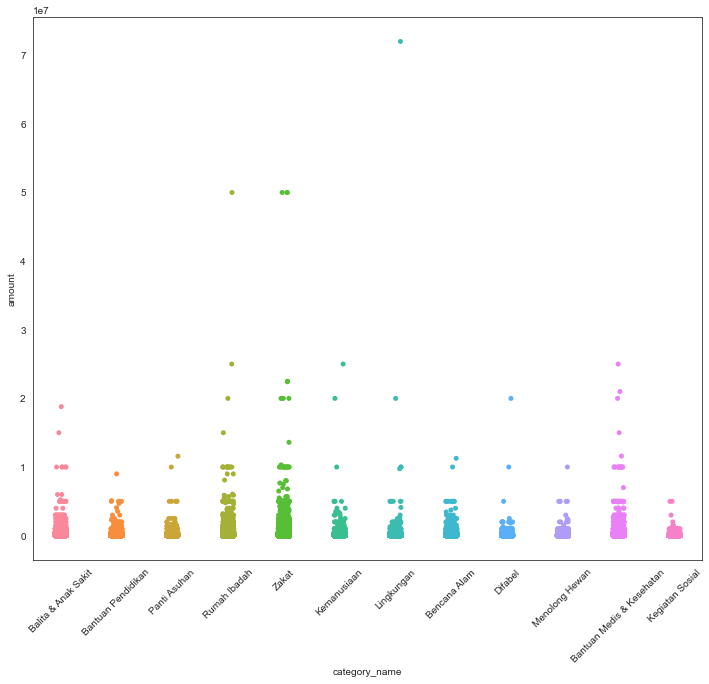

In [83]:
# Regression for category of the campaign
# 'Balita & Anak Sakit' as the base for the regression
regression_category('category_name')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     37.08
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           3.10e-45
Time:                        09:54:34   Log-Likelihood:            -1.8335e+07
No. Observations:             1354060   AIC:                         3.667e+07
Df Residuals:                 1354053   BIC:                         3.667e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.958e+04    424.590     69.668      0.000    2.87e+04    3.04e+04
day_ts[T.Monday]    -5871.6523    616.148     -9.530      0.000   -7079.282   -4664.023
day_ts[T.Saturday]  -4509.1309    639.535     -7.051      0.000   -5762.597   -3255.664
day_ts[T.Sunday]    -8034.3576    605.713    -13.264      0.000   -9221.535   -6847.180
day_ts[T.Thursday]  -5531.9143    540.285    -10.239      0.000   -6590.854   -4472.975
day_ts[T.Tuesday]   -6936.0158    602.968    -11.503      0.000   -8117.813   -5754.219
day_ts[T.Wednesday] -6461.3636    605.589    -10.670      0.000   -7648.298   -5274.430
==============================================================================
Omnibus:                  5925145.054   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   74538019365502.406
Skew:                         136.402   Prob(JB):                         0.00
Kurtosis:                   36349.564   Cond. No.                         8.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

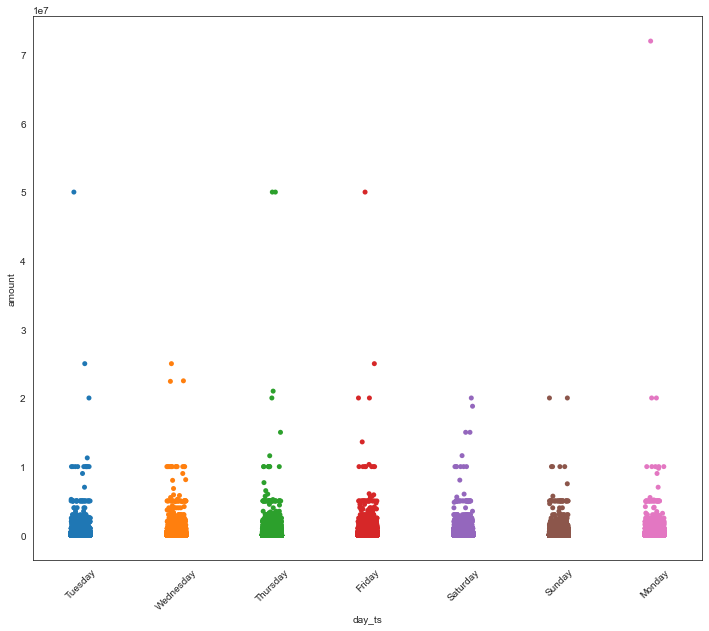

In [84]:
# Regression for day the donation is being made
# 'Friday' as the base for the regression
regression_category('day_ts')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5250.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:54:55   Log-Likelihood:            -1.8332e+07
No. Observations:             1354060   AIC:                         3.666e+07
Df Residuals:                 1354058   BIC:                         3.666e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.728e+04    355.077    133.166      0.000    4.66e+04     4.8e+04
is_anonymous[T.True] -2.871e+04    396.296    -72.455      0.000   -2.95e+04   -2.79e+04
==============================================================================
Omnibus:                  5933385.863   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   75496916692560.594
Skew:                         137.036   Prob(JB):                         0.00
Kurtosis:                   36582.611   Cond. No.                         4.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

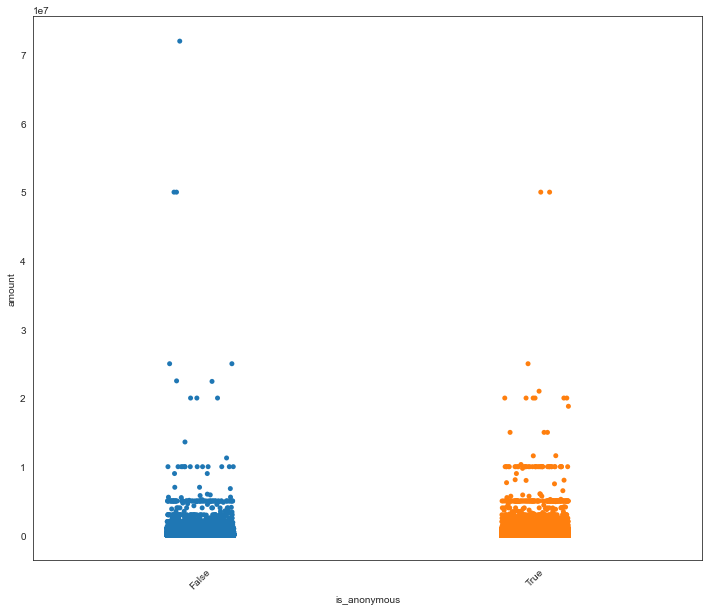

In [85]:
# Regression for the anonimity of the donor's profile 
# IS NOT anonym as the base
regression_category('is_anonymous')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     343.1
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           1.38e-76
Time:                        09:55:16   Log-Likelihood:            -1.8335e+07
No. Observations:             1354060   AIC:                         3.667e+07
Df Residuals:                 1354058   BIC:                         3.667e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.353e+04    162.511    144.767      0.000    2.32e+04    2.38e+04
profile_pic[T.1]  1.282e+04    692.095     18.523      0.000    1.15e+04    1.42e+04
==============================================================================
Omnibus:                  5925128.825   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   74522113698952.047
Skew:                         136.401   Prob(JB):                         0.00
Kurtosis:                   36345.685   Cond. No.                         4.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

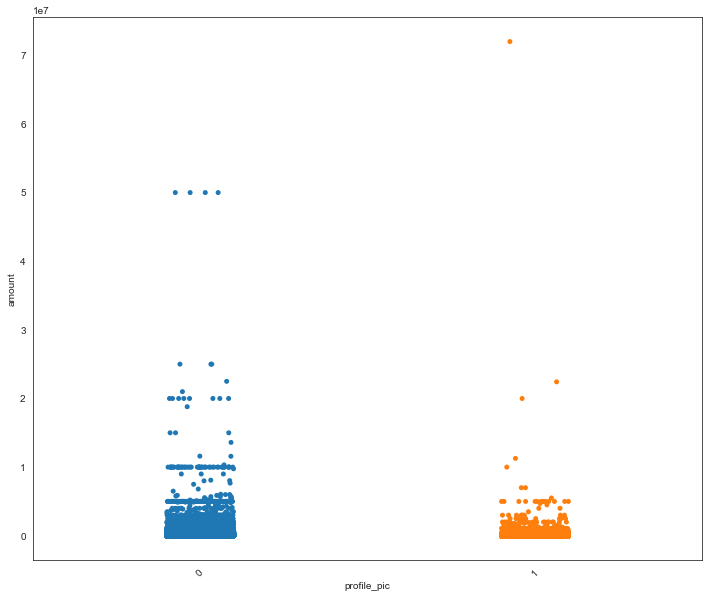

In [86]:
# Regression for day the donation is being made
# IS NOT anonym as the base
regression_category('profile_pic')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1883.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:55:28   Log-Likelihood:            -1.8334e+07
No. Observations:             1354060   AIC:                         3.667e+07
Df Residuals:                 1354058   BIC:                         3.667e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.782e+04    216.228     82.418      0.000    1.74e+04    1.82e+04
is_verified[T.True]  1.373e+04    316.449     43.399      0.000    1.31e+04    1.44e+04
==============================================================================
Omnibus:                  5927703.223   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   74846543844152.453
Skew:                         136.598   Prob(JB):                         0.00
Kurtosis:                   36424.709   Cond. No.                         2.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

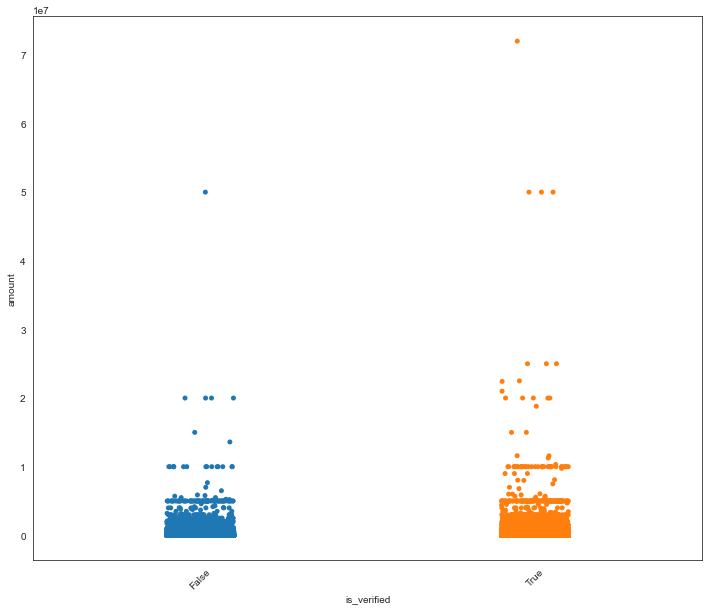

In [87]:
# Regression for the verification of the donation
# IS NOT anonym as the base
regression_category('is_verified')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1988.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:55:45   Log-Likelihood:            -1.8334e+07
No. Observations:             1354060   AIC:                         3.667e+07
Df Residuals:                 1354058   BIC:                         3.667e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    2.104e+04    173.342    121.387      0.000    2.07e+04    2.14e+04
campaigner_type[T.PERSONAL]  1.872e+04    419.762     44.587      0.000    1.79e+04    1.95e+04
==============================================================================
Omnibus:                  5928108.536   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   74878145056263.734
Skew:                         136.630   Prob(JB):                         0.00
Kurtosis:                   36432.397   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

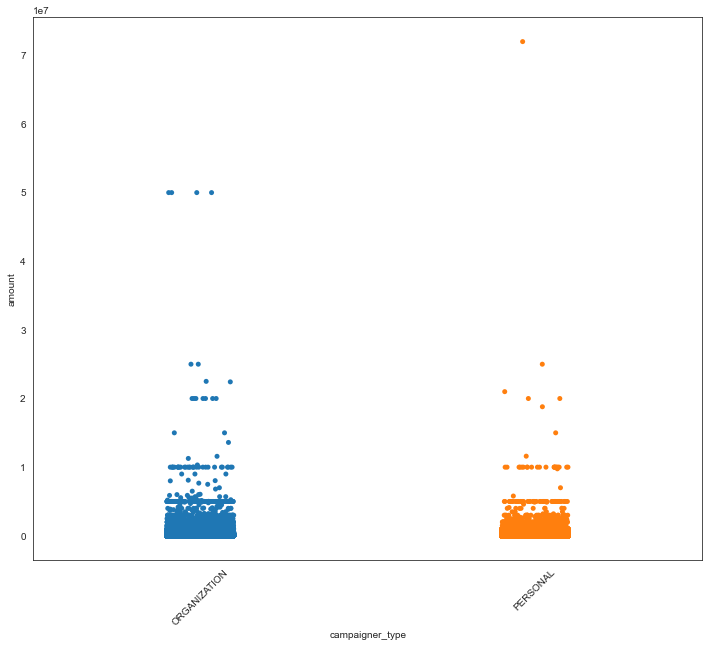

In [88]:
# Regression for campaigner type of the campaign
# The campaigner is ORGANIZATION as the base
regression_category('campaigner_type')

Final regression, I put every variables that have significance effect to amount of donation:

- Category
- Days
- Anonimity
- Campaigner type
- Verified

To check, which variable that has most impact to the amount of the donation.

In [141]:
# Function to calculate regression on all variables that have significance effect to amount of donation

def regression_category_all(cat='pooled'):
    
    df = df_statistics
    df = df.drop(df[(df['progress_bin'] == 10) | (df['progress_bin'] == 'over')].index)
    df['progress_bin'] = df['progress_bin'].cat.remove_unused_categories()
    
    if cat == 'below_threshold' or cat == 'above_threshold':
        df = df[df['days_category'] == cat]
    elif cat == 'pooled':
        pass
    
    df = df.rename(columns={'category.name': 'category_name',
                            'campaigner.type': 'campaigner_type',
                            'user.string': 'profile_pic'})

    est = smf.ols(formula='amount ~ percentage_progress + days_category + day_ts + is_anonymous + category_name + campaigner_type + is_verified + donation_target', data=df).fit()
    
    return est.summary()

regression_category_all()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     641.2
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:48:59   Log-Likelihood:            -1.6311e+07
No. Observations:             1213156   AIC:                         3.262e+07
Df Residuals:                 1213132   BIC:                         3.262e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   3.128e+04   1008.152     31.028      0.000    2.93e+04    3.33e+04
days_category[T.below_threshold]           -5635.1482    663.658     -8.491      0.000   -6935.894   -4334.402
day_ts[T.Monday]                           -2898.2155    598.669     -4.841      0.000   -4071.587   -1724.844
day_ts[T.Saturday]                         -4069.8585    617.554     -6.590      0.000   -5280.243   -2859.474
day_ts[T.Sunday]                           -6259.5644    585.438    -10.692      0.000   -7407.004   -5112.125
day_ts[T.Thursday]                         -3183.4455    527.783     -6.032      0.000   -4217.882   -2149.009
day_ts[T.Tuesday]                          -2600.5603    587.955     -4.423      0.000   -3752.932   -1448.188
day_ts[T.Wednesday]                        -3065.0822    590.148     -5.194      0.000   -4221.753   -1908.412
is_anonymous[T.True]                       -2.217e+04    407.916    -54.344      0.000    -2.3e+04   -2.14e+04
category_name[T.Bantuan Medis & Kesehatan]  4.306e+04   1016.875     42.348      0.000    4.11e+04    4.51e+04
category_name[T.Bantuan Pendidikan]         5282.1793   1138.718      4.639      0.000    3050.330    7514.028
category_name[T.Bencana Alam]                203.7756    886.178      0.230      0.818   -1533.104    1940.655
category_name[T.Difabel]                    4.942e+04   2200.593     22.456      0.000    4.51e+04    5.37e+04
category_name[T.Kegiatan Sosial]           -1.416e+04   1074.867    -13.176      0.000   -1.63e+04   -1.21e+04
category_name[T.Kemanusiaan]                1.945e+04    963.055     20.194      0.000    1.76e+04    2.13e+04
category_name[T.Lingkungan]                -3095.1768   1348.407     -2.295      0.022   -5738.008    -452.346
category_name[T.Menolong Hewan]             6692.9205   1310.695      5.106      0.000    4124.002    9261.839
category_name[T.Panti Asuhan]                1.29e+04   1462.066      8.821      0.000       1e+04    1.58e+04
category_name[T.Rumah Ibadah]               1.686e+04    941.427     17.911      0.000     1.5e+04    1.87e+04
category_name[T.Zakat]                      3016.7843    897.350      3.362      0.001    1258.008    4775.561
campaigner_type[T.PERSONAL]                 1.662e+04    796.234     20.868      0.000    1.51e+04    1.82e+04
is_verified[T.True]                         9820.0198    452.423     21.705      0.000    8933.286    1.07e+04
percentage_progress                        -8407.9599    601.484    -13.979      0.000   -9586.847   -7229.073
donation_target                             2.826e-06   8.84e-08     31.958      0.000    2.65e-06       3e-06
==============================================================================
Omnibus

In [142]:
regression_category_all('below_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     315.1
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:49:59   Log-Likelihood:            -3.2859e+06
No. Observations:              244904   AIC:                         6.572e+06
Df Residuals:                  244886   BIC:                         6.572e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   1.428e+04   2157.600      6.620      0.000    1.01e+04    1.85e+04
day_ts[T.Monday]                            2581.4396   1329.452      1.942      0.052     -24.252    5187.131
day_ts[T.Saturday]                          2534.6705   1233.016      2.056      0.040     117.991    4951.350
day_ts[T.Sunday]                           -2677.3702   1131.912     -2.365      0.018   -4895.888    -458.853
day_ts[T.Thursday]                          -621.1298   1110.638     -0.559      0.576   -2797.952    1555.692
day_ts[T.Tuesday]                           9603.4247   1343.656      7.147      0.000    6969.895    1.22e+04
day_ts[T.Wednesday]                         5531.8457   1260.357      4.389      0.000    3061.579    8002.113
is_anonymous[T.True]                       -7641.4747    709.678    -10.768      0.000   -9032.425   -6250.524
category_name[T.Bantuan Medis & Kesehatan]  2.232e+04   2269.284      9.835      0.000    1.79e+04    2.68e+04
category_name[T.Bencana Alam]              -1.075e+04   1330.345     -8.081      0.000   -1.34e+04   -8142.803
category_name[T.Kegiatan Sosial]           -7050.5699   1147.109     -6.146      0.000   -9298.873   -4802.267
category_name[T.Kemanusiaan]                1.394e+04   1146.132     12.162      0.000    1.17e+04    1.62e+04
category_name[T.Menolong Hewan]             2.094e+04   2424.783      8.635      0.000    1.62e+04    2.57e+04
category_name[T.Zakat]                      1.483e+04   1900.845      7.803      0.000    1.11e+04    1.86e+04
campaigner_type[T.PERSONAL]                 5389.6475   1048.154      5.142      0.000    3335.294    7444.001
is_verified[T.True]                        -3196.7028   1807.064     -1.769      0.077   -6738.500     345.094
percentage_progress                         9015.9548   1327.658      6.791      0.000    6413.781    1.16e+04
donation_target                             2.047e-05   1.05e-06     19.465      0.000    1.84e-05    2.25e-05
==============================================================================
Omnibus:                   806040.578   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     318600529437.913
Skew:                          56.677   Prob(JB):                         0.00
Kurtosis:                    5589.522   Cond. No.                     1.05e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [143]:
regression_category_all('above_threshold')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     529.5
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:50:27   Log-Likelihood:            -1.3023e+07
No. Observations:              968252   AIC:                         2.605e+07
Df Residuals:                  968230   BIC:                         2.605e+07
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   5.008e+04   1660.988     30.153      0.000    4.68e+04    5.33e+04
day_ts[T.Monday]                           -5154.1894    676.825     -7.615      0.000   -6480.743   -3827.636
day_ts[T.Saturday]                         -6614.8192    713.012     -9.277      0.000   -8012.299   -5217.339
day_ts[T.Sunday]                           -7356.8413    683.429    -10.765      0.000   -8696.340   -6017.343
day_ts[T.Thursday]                         -4517.4623    604.378     -7.475      0.000   -5702.022   -3332.902
day_ts[T.Tuesday]                          -5604.8315    662.126     -8.465      0.000   -6902.576   -4307.086
day_ts[T.Wednesday]                        -5990.5518    670.565     -8.934      0.000   -7304.836   -4676.267
is_anonymous[T.True]                       -2.786e+04    496.306    -56.129      0.000   -2.88e+04   -2.69e+04
category_name[T.Bantuan Medis & Kesehatan]  1.473e+04   2515.194      5.855      0.000    9797.377    1.97e+04
category_name[T.Bantuan Pendidikan]        -5692.8479   1628.893     -3.495      0.000   -8885.424   -2500.271
category_name[T.Bencana Alam]              -9925.9735   1586.707     -6.256      0.000    -1.3e+04   -6816.081
category_name[T.Difabel]                    2.937e+04   2484.976     11.821      0.000    2.45e+04    3.42e+04
category_name[T.Kemanusiaan]                1.549e+04   1934.374      8.010      0.000    1.17e+04    1.93e+04
category_name[T.Lingkungan]                -3.285e+04   1803.589    -18.214      0.000   -3.64e+04   -2.93e+04
category_name[T.Menolong Hewan]            -3.496e+04   2101.650    -16.635      0.000   -3.91e+04   -3.08e+04
category_name[T.Panti Asuhan]               1775.3944   1876.269      0.946      0.344   -1902.030    5452.818
category_name[T.Rumah Ibadah]               5571.1054   1507.745      3.695      0.000    2615.976    8526.235
category_name[T.Zakat]                     -7226.1822   1523.338     -4.744      0.000   -1.02e+04   -4240.492
campaigner_type[T.PERSONAL]                 3.507e+04   1452.322     24.148      0.000    3.22e+04    3.79e+04
is_verified[T.True]                             1e+04    511.518     19.557      0.000    9000.983     1.1e+04
percentage_progress                        -1.246e+04    679.215    -18.348      0.000   -1.38e+04   -1.11e+04
donation_target                             2.754e-06   9.19e-08     29.965      0.000    2.57e-06    2.93e-06
==============================================================================
Omnibus:                  4063824.517   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   30931993568279.039
Skew:                         118.947   Prob(JB):                      

# Notes 

Will be updated every time I made a new progress or findings.

**1. Looks like that I found a pattern when thresholding the day to 360 days (1 year).**

I suspected for donations that already passed 1 year since they started raising the fund, they extended or re-open again the donation after the donation expired or closed.

In [90]:
df_analysis[df_analysis['days_category'] == 'below_threshold']['short_url'].unique()

array(['ybkbantudomilawanpenyakitkulitlangka',
       'bantuadikfaizsembuhdaritumormata', 'maritolonganabul',
       'yukinfaqyatim', 'patunganuntukanabul',
       'lawanleukemiaakutabizaralamilumpuhdankritis',
       'tuhanbantudarentransplantasisumsumtulang',
       'bantukebutuhangizidekaisya', 'smbantuaiman',
       'zakatuntuksantritahfidzyatimpiatu', 'bantuhuskyaro',
       'operasibayiojol', 'bisausahapakrochim', 'bantuanmedisuntukpasien',
       'bergerakbangunmck', 'kitabantudikrayyan', 'bersamabantusembuh',
       'bantuanuntukkesehatan', 'sedekahberbagisajadah',
       'bisalekassembuh', 'prayforkanjuruhan',
       'tlgbayifrandapnyktjantungatresiaanisuspekdownsyndrome',
       'moaindonesiaforkanjuruhan', 'engeneindonesiaforkanjuruhan'],
      dtype=object)

In [91]:
df_analysis

,id,created_ts,day_ts,user.string,is_anonymous,amount,cumsum_amt,donation_target,percentage_progress,days_passed,...,category.name,short_url,start_ts_utc,time_scraped,progress_bin,progress_bin_50pct,created_timedelta,created_timedelta_s,order,days_category
0,179444.0,2016-10-25 18:13:00-07:00,Tuesday,0,True,50248.0,50248.0,200000000,0.000251,28 days 20:03:19,...,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47,1,below50,28 days 20:03:19,2491399.0,1,above_threshold
1,179533.0,2016-10-25 19:53:02-07:00,Tuesday,0,True,20794.0,71042.0,200000000,0.000355,28 days 21:43:21,...,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47,1,below50,0 days 01:40:02,6002.0,2,above_threshold
2,179535.0,2016-10-25 19:54:10-07:00,Tuesday,0,True,20795.0,91837.0,200000000,0.000459,28 days 21:44:29,...,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47,1,below50,0 days 00:01:08,68.0,3,above_threshold
3,179599.0,2016-10-25 20:49:46-07:00,Tuesday,0,False,500408.0,592245.0,200000000,0.002961,28 days 22:40:05,...,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47,1,below50,0 days 00:55:36,3336.0,4,above_threshold
4,180525.0,2016-10-26 22:09:51-07:00,Wednesday,0,True,100921.0,693166.0,200000000,0.003466,30 days 00:00:10,...,Balita & Anak Sakit,nyfara,2016-09-27 05:09:41,2022-10-05 10:38:47,1,below50,1 days 01:20:05,91205.0,5,above_threshold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354055,90951670.0,2022-10-11 07:08:09-07:00,Tuesday,0,False,39000.0,20000230.0,20000000,1.000012,6 days 02:56:28,...,Kegiatan Sosial,engeneindonesiaforkanjuruhan,2022-10-05 11:11:41,2022-10-12 09:55:43,over,above50,0 days 04:02:50,14570.0,898,below_threshold
1354056,90957260.0,2022-10-11 08:46:22-07:00,Tuesday,0,True,10000.0,20010230.0,20000000,1.000511,6 days 04:34:41,...,Kegiatan Sosial,engeneindonesiaforkanjuruhan,2022-10-05 11:11:41,2022-10-12 09:55:43,over,above50,0 days 01:38:13,5893.0,899,below_threshold
1354057,90957677.0,2022-10-11 08:54:32-07:00,Tuesday,0,True,10000.0,20020230.0,20000000,1.001011,6 days 04:42:51,...,Kegiatan Sosial,engeneindonesiaforkanjuruhan,2022-10-05 11:11:41,2022-10-12 09:55:43,over,above50,0 days 00:08:10,490.0,900,below_threshold
1354058,90969802.0,2022-10-11 14:37:05-07:00,Tuesday,0,True,2000.0,20022230.0,20000000,1.001111,6 days 10:25:24,...,Kegiatan Sosial,engeneindonesiaforkanjuruhan,2022-10-05 11:11:41,2022-10-12 09:55:43,over,above50,0 days 05:42:33,20553.0,901,below_threshold


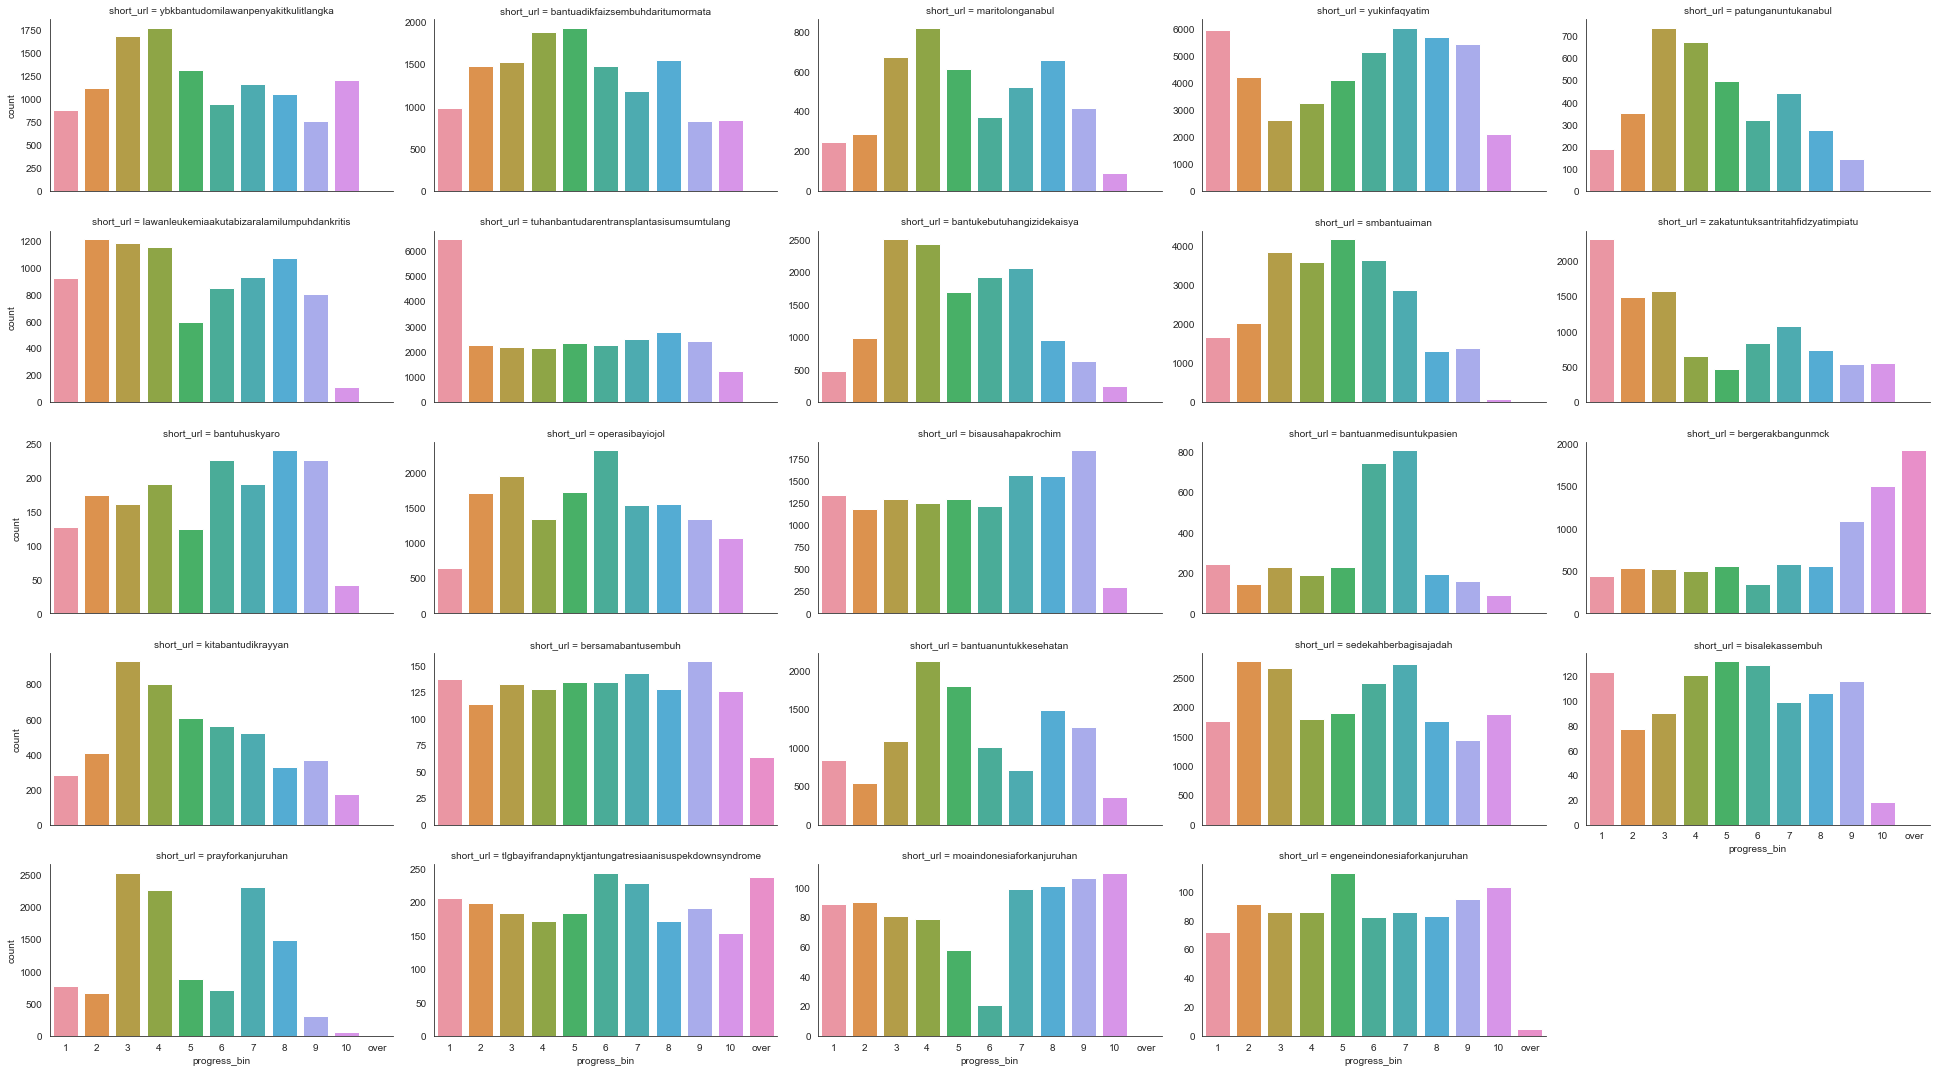

In [92]:
def plot_by_days(params):  #params -> 'below_threshold' or 'above_threshold'
    df = df_analysis[df_analysis['days_category'] == params]
    sns.catplot(data=df, 
                kind='count',
                x='progress_bin',
                col='short_url',
                col_wrap=5, height=3, aspect=1.8,
                sharey=False)  # to separate y-axis to its own category
    plt.tight_layout()
    plt.show()

plot_by_days('below_threshold')

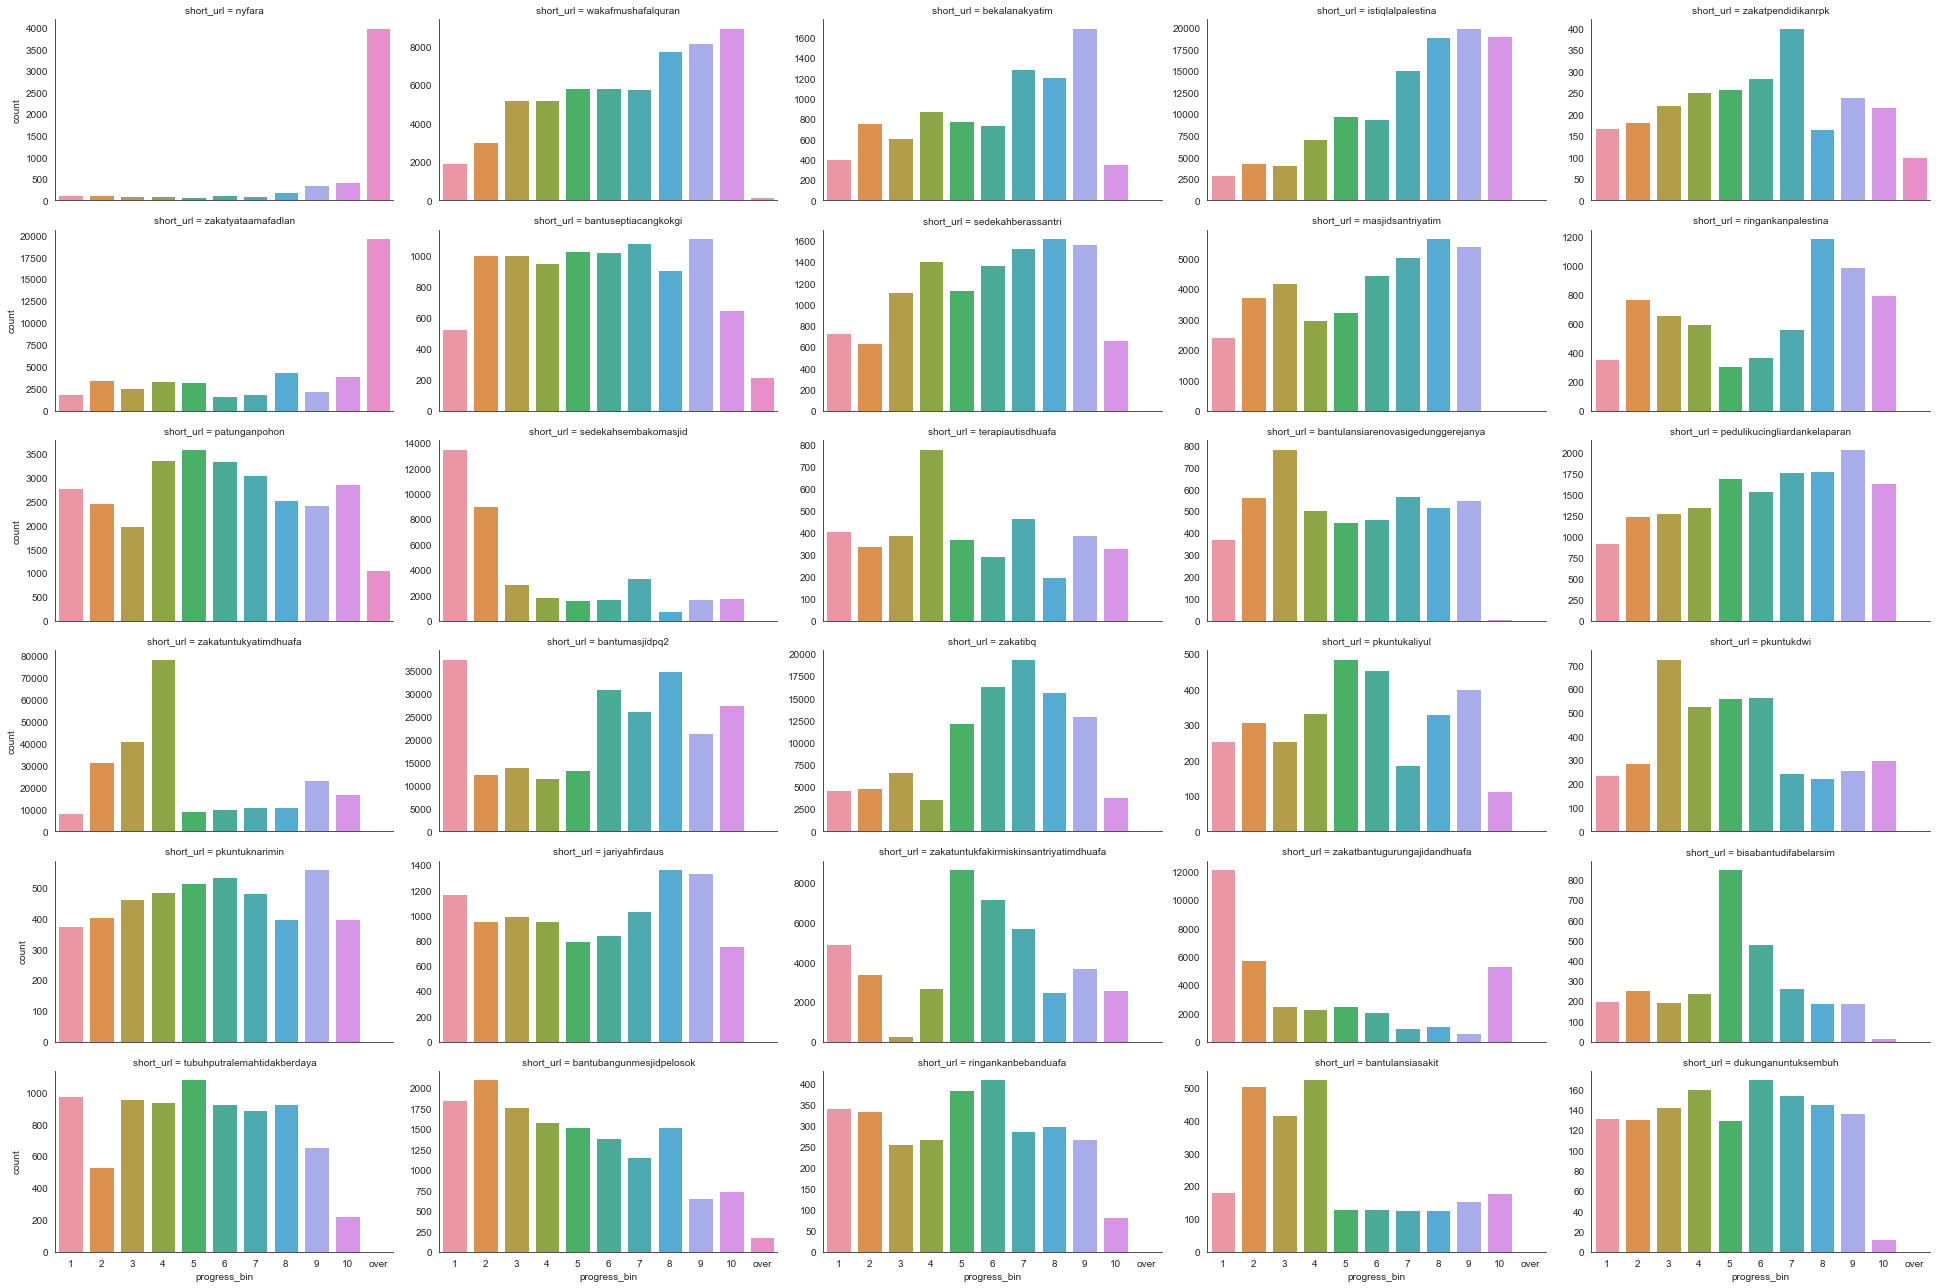

In [93]:
plot_by_days('above_threshold')

In [94]:
dayspassed_cat[dayspassed_cat['days_category'] == 'above_threshold']

,short_url,days_passed,created_timedelta,days_category
3,bantubangunmesjidpelosok,256 days 06:19:06,55 days 05:33:22,above_threshold
6,bantulansiarenovasigedunggerejanya,640 days 00:30:19,7 days 20:28:03,above_threshold
7,bantulansiasakit,203 days 10:02:46,59 days 16:51:33,above_threshold
8,bantumasjidpq2,600 days 01:11:03,12 days 20:13:22,above_threshold
9,bantuseptiacangkokgi,1289 days 20:04:34,138 days 14:25:05,above_threshold
10,bekalanakyatim,1416 days 21:05:13,33 days 04:55:02,above_threshold
13,bisabantudifabelarsim,313 days 21:04:35,52 days 22:50:52,above_threshold
16,dukunganuntuksembuh,37 days 19:53:19,32 days 03:49:42,above_threshold
18,istiqlalpalestina,1395 days 13:26:57,4 days 16:11:35,above_threshold
19,jariyahfirdaus,447 days 01:53:39,263 days 12:27:05,above_threshold


In [95]:
dayspassed_cat[dayspassed_cat['days_category'] == 'below_threshold']

,short_url,days_passed,created_timedelta,days_category
0,bantuadikfaizsembuhdaritumormata,266 days 01:39:01,14 days 00:39:56,below_threshold
1,bantuanmedisuntukpasien,37 days 07:33:39,4 days 09:05:34,below_threshold
2,bantuanuntukkesehatan,33 days 03:42:29,17 days 10:01:53,below_threshold
4,bantuhuskyaro,86 days 06:29:31,6 days 11:02:26,below_threshold
5,bantukebutuhangizidekaisya,162 days 19:30:22,17 days 04:05:01,below_threshold
11,bergerakbangunmck,16 days 19:10:45,0 days 18:28:17,below_threshold
12,bersamabantusembuh,36 days 21:17:23,15 days 16:09:05,below_threshold
14,bisalekassembuh,27 days 15:11:49,10 days 06:08:44,below_threshold
15,bisausahapakrochim,66 days 11:10:14,6 days 07:30:50,below_threshold
17,engeneindonesiaforkanjuruhan,6 days 11:01:14,1 days 22:07:46,below_threshold


**2. The p-value is always significant because of the sample size. Instead, using q-value.**

If, on the other hand, you want to make some judgement as to whether to treat a particular coefficient as statistically significant or not, you might want to take Good's (1982) suggestion as summarized in Woolley (2003): Calculate the q-value as 𝑝⋅(𝑛/100) which standardizes p-values to a sample size of 100. A p-value of exactly .001 converts to a p-value of .045 -- statistically significant still.

https://stats.stackexchange.com/questions/22233/how-to-choose-significance-level-for-a-large-data-set